<a href="https://colab.research.google.com/github/ahmad-PH/nag-notebooks/blob/master/NAG_tripletLossExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [236]:
import subprocess
def run_shell_command(cmd):
  p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
  print(str(p.communicate()[0], 'utf-8'))


def detect_env():
    import os
    if 'content' in os.listdir('/'):
      return "colab"
    else:
      return "IBM"
  
def create_env():
  if detect_env() == "IBM":
    return IBMEnv()
  elif detect_env() == "colab":
    return ColabEnv()


class Env:
  def get_nag_util_files(self):
      import os
      
      print("\ngetting git files ...")
      if os.path.isdir(self.python_files_path):
        os.chdir(self.python_files_path)
        run_shell_command('git pull')
        os.chdir(self.root_folder)
      else:
        run_shell_command('git clone https://github.com/ahmad-PH/nag-public.git')
      print("done.")
      
  def get_csv_path(self):
    return self.get_csv_dir() + self.save_filename
  
  def get_models_path(self):
    return self.get_models_dir() + self.save_filename
  

class IBMEnv(Env):
    def __init__(self):
      self.root_folder = "/root/Derakhshani/adversarial"
      self.temp_csv_path = self.root_folder + "/temp"
      self.python_files_path = self.root_folder + "/nag-public"
      self.python_files_dir = "NAG-11May-beforeDenoiser"
      
      import sys
      sys.path.append('./nag/nag_util')
    
    def get_csv_dir(self):
      return self.root_folder + "/textual_notes/CSVs/"
    
    def get_models_dir(self):
      return self.root_folder + "/models/"
    
    def setup(self):
      self.get_nag_util_files()
      
      import os; import torch;
      os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
      cuda_index = 0
      os.environ['CUDA_VISIBLE_DEVICES']=str(cuda_index)
#       defaults.device = torch.device('cuda:' + str(cuda_index))
#       print('cuda:' + str(cuda_index))
#       torch.cuda.set_device('cuda:1')
      
    def load_dataset(self, compressed_name, unpacked_name):
      pass

    def load_test_dataset(self, root_folder):
      pass
    
    def set_data_path(self, path):
      self.data_path = Path(self.root_folder + '/datasets/' + path)
    
        
class ColabEnv(Env):
    def __init__(self):
      self.root_folder = '/content'
      self.temp_csv_path = self.root_folder
      self.python_files_path = self.root_folder + '/nag-public'
      self.python_files_dir = "NAG-11May-beforeDenoiser"
      self.torchvision_upgraded = False
      
    def get_csv_dir(self):
      return self.root_folder + '/gdrive/My Drive/DL/textual_notes/CSVs/'
    
    def get_models_dir(self):
      return self.root_folder + '/gdrive/My Drive/DL/models/'
        
    def setup(self):
        # ######################################################
        # # TODO remove this once torchvision 0.3 is present by
        # # default in Colab
        # ######################################################
        global torchvision_upgraded
        try:
            torchvision_upgraded
        except NameError:
          !pip uninstall -y torchvision
          !pip install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl
          torchvision_upgraded = True
        else:
          print("torchvision already upgraded")
          
        from google.colab import drive
        drive.mount('/content/gdrive')
        
        self.get_nag_util_files()
        
    def load_dataset(self, compressed_name, unpacked_name):
      if compressed_name not in os.listdir('.'):
        print(compressed_name + ' not found, getting it from drive')
        shutil.copyfile("/content/gdrive/My Drive/DL/{}.tar.gz".format(compressed_name), "./{}.tar.gz".format(compressed_name))

        gunzip_arg = "./{}.tar.gz".format(compressed_name)
        !gunzip -f $gunzip_arg

        tar_arg = "./{}.tar".format(compressed_name)
        !tar -xvf $tar_arg > /dev/null

        os.rename(unpacked_name, compressed_name)

    #     ls_arg = "./{}/train/n01440764".format(compressed_name)
    #     !ls $ls_arg

        !rm $tar_arg

        print("done") 
      else:
        print(compressed_name + " found")
        
    def load_test_dataset(self, root_folder):
      test_folder = root_folder + '/test/'
      if 'test' not in os.listdir(root_folder):
        print('getting test dataset from drive')
        os.mkdir(test_folder)
        for i in range(1,11):
          shutil.copy("/content/gdrive/My Drive/DL/full_test_folder/{}.zip".format(i), test_folder)
          shutil.unpack_archive(test_folder + "/{}.zip".format(i), test_folder)
          os.remove(test_folder + "/{}.zip".format(i))
          print("done with the {}th fragment".format(i))
      else:
        print('test dataset found.')
        
    def set_data_path(self, path):
      self.data_path = Path('./' + path)
        

In [237]:
env = create_env()
env.setup()


getting git files ...
Already up-to-date.

done.


In [238]:
from fastai.vision import *
from fastai.imports import *
from fastai.callbacks import *
from fastai.utils.mem import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import sys; import os; import shutil

In [239]:
sys.path.append(env.python_files_path + '/' + env.python_files_dir)

from nag_util import *
import nag_util

In [240]:
from functools import partial
from torch.nn import init
from typing import Iterable
torch.Tensor.ndim = property(lambda x: len(x.shape))

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, Iterable): return list(o)
    return [o]

class ListContainer():
  def __init__(self, items): self.items = listify(items)
  def __getitem__(self, idx):
    if isinstance(idx, (int, slice)): return self.items[idx]
    if isinstance(idx[0], bool):
      assert len(idx) == len(self)
      return [o for m,o in zip(idx, self.items) if m]
    return [self.items[i] for i in idx]
  
  def __len__(self): return len(self.items)
  def __iter__(self): return iter(self.items)
  def __setitem__(self, i, o): self.items[i] = o
  def __delitem__(self, i): del(self.items[i])
  def __repr__(self):
    res = f"{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}"
    if len(self)>10: res = res[:-1] + "...]"
    return res

def children(m): return list(m.children())

def append_stats_non_normal(hook, mod, inp, outp):
  if not hasattr(hook,'stats'): hook.stats = ([],[],[])
  means,stds,hists = hook.stats
  means.append(outp.data.mean().cpu())
  stds .append(outp.data.std().cpu())
  hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

def append_stats_normal(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

def get_hist(h):
  return torch.stack(h.stats[2]).t().float().log1p()

def get_min(h):
  h1 = torch.stack(h.stats[2]).t().float()
  return h1[:2].sum(0)/h1.sum(0)

class Hook():
  def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
  def __del__(self): self.remove()
  def remove(self): self.hook.remove()
    
class Hooks(ListContainer):
  def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms.children()])
  def __enter__(self, *args): return self
  def __exit__ (self, *args): self.remove()
  def __del__(self): self.remove()

  def __delitem__(self, i):
    self[i].remove()
    super().__delitem__(i)

  def remove(self):
    for h in self: h.remove()

def init_cnn_(m, f):
    if isinstance(m, nn.ConvTranspose2d):
      f(m.weight, a=0.1)
      if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
        
    #non-orthogonal
    if isinstance(m, nn.Linear):
      f(m.weight, a=0.)
      if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
        
    #orthogonal
#     if isinstance(m, nn.Linear):
#       init.orthogonal_(m.weight)
#       m.bias.data.zero_()

    for l in m.children(): init_cnn_(l, f)  
      
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

class GeneralRelu(nn.Module):
  def __init__(self, leak=None, sub=None, maxv=None):
    super().__init__()
    self.leak,self.sub,self.maxv = leak,sub,maxv

  def forward(self, x): 
    x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
    if self.sub is not None: x.sub_(self.sub)
    if self.maxv is not None: x.clamp_max_(self.maxv)
    return x
  
class deconv_layer(nn.Module):
    def __init__(self, in_ch, out_ch, k_size = (4,4), s = (2,2), pad = (1,1), b = True, activation = True):
        super(deconv_layer, self).__init__()

        self.CT2d = nn.ConvTranspose2d(in_channels = in_ch,
                                  out_channels = out_ch,
                                  kernel_size = k_size,
                                  stride = s, 
                                  padding = pad,
                                  bias = b)
        self.BN2d = nn.BatchNorm2d(out_ch)
        
        self.activation = activation
        if self.activation:
            self.relu = GeneralRelu(0, 0.2, 5)
        
        self.weight_init()
    
    def forward(self, input):
        if self.activation:
            return self.relu(self.BN2d(self.CT2d(input)))
        else:
            return self.BN2d(self.CT2d(input))

    def weight_init(self):
        self.CT2d.weight.data.normal_(mean = 0, std = 0.02)
        self.CT2d.bias.data.fill_(0)


In [241]:
# mode = "sanity_check"
mode = "normal"
# mode = "div_metric_calc"

In [242]:
model = models.resnet50
# model = models.resnet152
# model = models.vgg16_bn
# model = torchvision.models.googlenet

In [243]:
if mode == "normal":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
elif mode == "sanity_check":
  env.load_dataset('dataset_sanity_check_small', 'dataset_sanity_check_small')  
  env.set_data_path('dataset_sanity_check_small')
elif mode == "div_metric_calc":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
  env.load_test_dataset(str(env.data_path))

In [244]:
batch_size = 16
gpu_flag = True
nag_util.batch_size = batch_size; nag_util.gpu_flag = gpu_flag;
# nag_util.set_globals(gpu_flag, batch_size)
tfms = get_transforms(do_flip=False, max_rotate=0)
data = (ImageList.from_folder(env.data_path)
        .split_by_folder(valid=('test' if mode == 'div_metric_calc' else 'valid'))
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=batch_size, num_workers=1)
        .normalize(imagenet_stats))

# data.show_batch(rows=2, figsize=(5,5))

In [245]:
model_name = model.__name__
z_dim = 10
arch = SoftmaxWrapper(model(pretrained=True).cuda().eval())
nag_util.arch = arch
requires_grad(arch, False)

# vgg:
# layers = []
# blocks = [i-1 for i,o in enumerate(children(arch.features)) if isinstance(o, nn.MaxPool2d)]
# layers = [arch.features[i] for i in blocks]
# layer_weights = [1] * len(layers)

layers = [
    arch.softmax
]

layer_weights = [1.] * len(layers)

# inception:
# layers = [
#     arch.Conv2d_1a_3x3,
#     arch.Mixed_6e,
#     arch.Mixed_7a,
#     arch.fc    
# ]
# layer_weights = [1.0/4.0] * len(layers)

In [246]:
# class Gen(nn.Module):
#   def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
#     super(Gen, self).__init__()

#     self.bs = None
#     self.z_dim = z_dim
#     self.gf_dim = gf_dim
#     self.y_dim = y_dim
#     self.df_dim = df_dim
#     self.image_shape = image_shape

#     self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
#     self.z_.bias.data.fill_(0)
#     self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

#     self.half = max(self.gf_dim // 2, 1) 
#     self.quarter = max(self.gf_dim // 4, 1)
#     self.eighth = max(self.gf_dim // 8, 1)
#     # sixteenth = max(self.gf_dim // 16, 1)
    
#     self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
#     self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)    
#     self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)
#     self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)
#     self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
#     self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
#     self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

#   def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
#     h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
#     h_input = torch.cat([h_input, h_input_z], dim = 1)
#     output = deconv_layer(h_input)
#     assert output.shape[2:] == (expected_output_size, expected_output_size), \
#             "Unexpected output shape at randomized_deconv_layer. expected" + \
#             "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
#     return output
  
#   def forward_z(self, z):
#     self.bs = z.shape[0]
    
#     h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
#     assert h0.shape[2:] == (4, 4), "Unexpected shape, it shoud be (4,4)"

#     h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
#     h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
#     h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
#     h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
#     h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
#     h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
#     h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

#     ksi = 10.0
#     output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
#     # this coeff scales the output to be appropriate for images that are 
#     # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
#     # interval)
#     return output_coeff * torch.tanh(h7)
  
# #   # blind-selection
#   def forward(self, inputs):
#     self.bs = inputs.shape[0]

#     benign_preds_onehot = arch(inputs)
#     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
#     z = torch.zeros([self.bs, 1000]).cuda()
#     for i in range(self.bs):
#       random_label = self.randint(0,1000, exclude = benign_preds[i].item())
#       z[i][random_label] = 1.
    
#     z_out = self.forward_z(z)
    
#     return z_out, None, None, inputs, benign_preds_onehot, z

# #   #second-best selection: made validation so much worse
# #   def forward(self, inputs):
# #     self.bs = inputs.shape[0]

# #     benign_preds_onehot = arch(inputs)
# #     target_preds = torch.topk(benign_preds_onehot, 2, dim = 1).indices[:, 1:]
    
# #     z = torch.zeros([self.bs, 1000]).cuda()
# #     for i in range(self.bs):
# #       z[i][target_preds[i]] = 1.
    
# #     z_out = self.forward_z(z)
    
# #     return z_out, None, None, inputs, benign_preds_onehot, z
  
# #    def forward(self, inputs):
# #     self.bs = inputs.shape[0]

# #     benign_preds_onehot = arch(inputs)
# #     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
# #     z = torch.zeros([self.bs, 1000]).cuda()
# #     random_label = self.randint(0,1000, exclude = benign_preds.tolist())
# #     for i in range(self.bs):
# #       z[i][random_label] = 1.
    
# #     z_out = self.forward_z(z)
    
# #     return z_out, None, None, inputs, benign_preds_onehot, z
  
#   @staticmethod
#   def randint(low, high, exclude):
#     temp = np.random.randint(low, high - 1)
#     if temp == exclude:
#       temp = temp + 1
#     return temp
  
#   def forward_single_z(self, z):
#     return self.forward_z(z[None]).squeeze()
           
  
#   def make_triplet_samples(self, z, margin, r2, r3):
#     positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
#     negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
#     return positive_sample, negative_sample

#   def random_vector_surface(self, shape, r = 1.):
#     mat = torch.randn(size=shape).cuda()
#     norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
#     return (mat/norm) * r

  
#   def random_vector_volume(self, shape, inner_r, outer_r):
#     fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
#     fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
#     fraction.unsqueeze_(-1)
#     return self.random_vector_surface(shape, 1) * fraction

#   def make_z(self, in_shape):
#     return torch.empty(in_shape).cuda().uniform_(-1,1)


In [247]:
# non-targeted Gen
class Gen(nn.Module):
  def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
    super(Gen, self).__init__()

    self.bs = None
    self.z_dim = z_dim
    self.gf_dim = gf_dim
    self.y_dim = y_dim
    self.df_dim = df_dim
    self.image_shape = image_shape

    self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
    self.z_.bias.data.fill_(0)
    self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

    self.half = max(self.gf_dim // 2, 1) 
    self.quarter = max(self.gf_dim // 4, 1)
    self.eighth = max(self.gf_dim // 8, 1)
    # sixteenth = max(self.gf_dim // 16, 1)

    self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
    self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)    
    self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)
    self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)
    self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
    self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
    self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

  def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
    h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
    h_input = torch.cat([h_input, h_input_z], dim = 1)
    output = deconv_layer(h_input)
    assert output.shape[2:] == (expected_output_size, expected_output_size), \
            "Unexpected output shape at randomized_deconv_layer. expected" + \
            "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
    return output
  
  def forward_z(self, z):
    self.bs = z.shape[0]
    
    h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
    assert h0.shape[2:] == (4, 4), "Non-expected shape, it shoud be (4,4)"

    h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
    h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
    h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
    h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
    h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
    h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
    h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

    ksi = 10.0
    output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
    # this coeff scales the output to be appropriate for images that are 
    # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
    # interval)
    return output_coeff * torch.tanh(h7)

  def forward(self, inputs):
    self.bs = inputs.shape[0]
    z = inputs.new_empty([self.bs, self.z_dim]).uniform_(-1,1).cuda()
    p, n = self.make_triplet_samples(z, 0.1, 0.1, 2.)
    
    z_out = self.forward_z(z)
    p_out = self.forward_z(p)
    n_out = self.forward_z(n)
    
    return z_out, p_out, n_out, inputs
#     return z_out, None, None, inputs
  
  def forward_single_z(self, z):
    return self.forward_z(z[None]).squeeze()
           
  
  def make_triplet_samples(self, z, margin, r2, r3):
    positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
    negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
    return positive_sample, negative_sample

  def random_vector_surface(self, shape, r = 1.):
    mat = torch.randn(size=shape).cuda()
    norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
    return (mat/norm) * r

  
  def random_vector_volume(self, shape, inner_r, outer_r):
    fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
    fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
    fraction.unsqueeze_(-1)
    return self.random_vector_surface(shape, 1) * fraction

  def make_z(self, in_shape):
    return torch.empty(in_shape).cuda().uniform_(-1,1)

In [248]:
def js_distance(x1, x2):
  m = 0.5 * (x1 + x2)
  return 0.5 * (F.kl_div(x1, m) + F.kl_div(x2, m))

def kl_distance(x1, x2):
  inp = torch.log(x1)
  target = x2
  return F.kl_div(inp, target, reduction='batchmean')

def distrib_distance(x1, x2):
  x1 = tensorify(x1)
  x2 = tensorify(x2)
  x1 = x1 / torch.sum(x1)
  x2 = x2 / torch.sum(x2)
  return kl_distance(x1[None], x2[None])

def distrib_distance(x1, x2):
  if not isinstance(x1, torch.Tensor): x1 = torch.tensor(x1)
  if not isinstance(x2, torch.Tensor): x2 = torch.tensor(x2)
  x1 = x1 * 100. / torch.sum(x1)
  x2 = x2 * 100. / torch.sum(x2)
  return torch.norm(x1 - x2, 2)

def distance_from_uniform(x):
  return distrib_distance(x, [1.] * len(x))

def wasserstein_distance(x1, x2):
  return torch.mean(x1 - x2)

def l1_distance(x1, x2):
  return F.l1_loss(x1, x2)

def l2_distance(x1, x2):
  return F.mse_loss(x1 * 10, x2 * 10)

def mse_loss(x1, x2):
  return F.mse_loss(x1, x2)

def cos_distance(x1, x2, dim = 1):
  return -1 * torch.mean(F.cosine_similarity(x1, x2, dim=dim))

triplet_call_cnt = 0

def triplet_loss(anchor, positive, negative, distance_func, margin):
  # max distance when using l1_distance is 2
  # max distacne when using l2-distance is sqrt(2)
#   print("anchor: ", anchor.min(), anchor.max())
  ap_dist = distance_func(anchor, positive)
  an_dist = distance_func(anchor, negative)

  global triplet_call_cnt
  triplet_call_cnt += 1
  if triplet_call_cnt % 10 in [0,1] : #and anchor.shape[1] == 1000:
    print("a: ", end=""); print_big_vector(anchor[0])
    print("p: ", end=""); print_big_vector(positive[0])
    print("n: ", end=""); print_big_vector(negative[0])
    print("func:{}, ap_dist: {}, an_dist: {}".format(distance_func.__name__, ap_dist, an_dist))
    
  return torch.mean(F.relu(ap_dist - an_dist + margin))

In [249]:
def diversity_loss(input, target):
#   return -1 * torch.mean(torch.pow(f_x_a-f_x_s,2))
  if input.shape[0] != batch_size:
    print("input shape: ", input.shape)
    print("target shape: ", target.shape, "\n\n")
  return torch.mean(F.cosine_similarity(
    input.view([batch_size, -1]),
    target.view([batch_size, -1]), 
  ))

fool_loss_count = 0

def fool_loss(input, target):
  true_class = torch.argmax(target, dim=1).view(-1,1).long().cuda()
  target_probabilities = input.gather(1, true_class)
  epsilon = 1e-10
  result =  torch.mean(-1 * torch.log(1 - target_probabilities + epsilon))
  
  global fool_loss_count
  fool_loss_count += 1
  if fool_loss_count % 40 == 0:
    print("target probs {}, loss: {}: ".format(target_probabilities, result))
    
  return result


# def fool_loss(model_output, target_labels):
#   target_labels = target_labels.view(-1, 1).long().cuda()
#   target_probabilities = model_output.gather(1, target_labels)
#   epsilon = 1e-10
#   # highest possible fool_loss is - log(1e-10) == 23
#   result = torch.mean(-1 * torch.log(target_probabilities + epsilon))
  
#   global fool_loss_count
#   fool_loss_count += 1
#   if fool_loss_count % 20 == 0:
#     print("target probs {}, loss: {}: ".format(target_probabilities, result))
  
#   return result

# def validation(gen_output, target):
#   perturbations, _, _, clean_images, _, _ = gen_output
#   perturbed_images = clean_images + perturbations
#   benign_preds = torch.argmax(arch(clean_images), 1)
#   adversary_preds = torch.argmax(arch(perturbed_images), 1)
#   return (benign_preds != adversary_preds).float().mean()

def validation(gen_output, target):
  perturbations, _, _, clean_images = gen_output
  perturbed_images = clean_images + perturbations
  benign_preds = torch.argmax(arch(clean_images), 1)
  adversary_preds = torch.argmax(arch(perturbed_images), 1)
  return (benign_preds != adversary_preds).float().mean()


In [250]:
# class FeatureLoss(nn.Module):
#     def __name__(self):
#       return "feature_loss"
  
#     def __init__(self, dis, layers, layer_weights):
#         super().__init__()
        
#         # define generator here 
#         self.dis = dis
#         self.diversity_layers = layers
#         self.hooks = hook_outputs(self.diversity_layers, detach=False)
#         self.weights = layer_weights
#         self.metric_names = ["fool_loss"] #+ [f"div_loss_{i}" for i in range(len(layers))] #maybe Gram
# #         self.triplet_hooks = hook_outputs([arch.m.features[4]], detach=False)
    
#     def make_features(self, x, clone=False):
#         y = self.dis(x)
#         return y, [(o.clone() if clone else o) for o in self.hooks.stored]
  
#     def forward(self, inp, target):
#       sigma_B, _, _, X_B, B_Y, z = inp

#       X_A = X_B + sigma_B
# #       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       A_Y, A_feat = self.make_features(X_A)
# #       _, S_feat = self.make_features(X_S)

#       chosen_labels = z.argmax(dim=1)
#       fooling_loss =  fool_loss(A_Y, chosen_labels)

# #       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
# #       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

# #       self.losses = [fooling_loss] + weighted_diversity_losses
# #       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

#       self.losses = [fooling_loss]
#       self.metrics = dict(zip(self.metric_names, [fooling_loss]))

#       return sum(self.losses)
  
#     def add_perturbation_shuffled(self, inp, perturbation):
# #         j = torch.randperm(inp.shape[0])
#         j = derangement(inp.shape[0])
#         return inp.add(perturbation[j])

In [251]:
#non-targeted FeatureLoss
class FeatureLoss(nn.Module):
    def __name__(self):
      return "feature_loss"
  
    def __init__(self, dis, layers, layer_weights):
        super().__init__()
        
        # define generator here 
        self.dis = dis
        self.diversity_layers = layers
        self.hooks = hook_outputs(self.diversity_layers, detach=False)
        self.weights = layer_weights
#         self.metric_names = ["fool_loss"] + [f"div_loss_{i}" for i in range(len(layers))] + ['triplet_loss']# Maybe Gram
        self.metric_names = ["fool_loss"] + ['triplet_loss']# Maybe Gram
        self.triplet_weight = 3.
        self.triplet_weight_noise = 5.
        self.triplet_weight_sm = 5.
    
    def make_features(self, x, clone=False):
        y = self.dis(x)
        return y, [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, inp, target):
        sigma_B, sigma_pos, sigma_neg, X_B = inp

        X_A = self.add_perturbation(X_B, sigma_B) 
        X_A_pos = self.add_perturbation(X_B, sigma_pos)
        X_A_neg = self.add_perturbation(X_B, sigma_neg) 
        
        X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples
        
        B_Y, _ = self.make_features(X_B)
        A_Y, A_feat = self.make_features(X_A)
#         _, S_feat = self.make_features(X_S)
        pos_softmax, _ = self.make_features(X_A_pos)
        neg_softmax, _ = self.make_features(X_A_neg)
        
        fooling_loss =  fool_loss(A_Y, B_Y)
      
#         raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#         weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
        raw_triplet_loss = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
        weighted_triplet_loss = raw_triplet_loss * self.triplet_weight
    
#         self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss]
#         self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss]))
        self.losses = [fooling_loss] + [weighted_triplet_loss]
        self.metrics = dict(zip(self.metric_names, [fooling_loss] + [raw_triplet_loss]))

        return sum(self.losses)

#     #use two types of triplet losses
#     def forward(self, inp, target):
#       sigma_B, sigma_pos, sigma_neg, X_B = inp

#       X_A = self.add_perturbation(X_B, sigma_B) 
#       X_A_pos = self.add_perturbation(X_B, sigma_pos)
#       X_A_neg = self.add_perturbation(X_B, sigma_neg) 

#       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       B_Y, _ = self.make_features(X_B)
#       A_Y, A_feat = self.make_features(X_A)
#       _, S_feat = self.make_features(X_S)
#       pos_softmax, _ = self.make_features(X_A_pos)
#       neg_softmax, _ = self.make_features(X_A_neg)

#       fooling_loss =  fool_loss(A_Y, B_Y)

#       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
      
#       raw_triplet_loss_sm = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
#       weighted_triplet_loss_sm = raw_triplet_loss_sm * self.triplet_weight_sm
      
#       raw_triplet_loss_noise = triplet_loss(sigma_B, sigma_pos, sigma_neg, l2_distance, 5.)
#       weighted_triplet_loss_noise = raw_triplet_loss_noise * self.triplet_weight_noise

#       self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise] 
#       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise]))

#       return sum(self.losses)

#     # just fooling and diversity
#     def forward(self, inp, target):
#       sigma_B, sigma_pos, sigma_neg, X_B = inp

#       X_A = self.add_perturbation(X_B, sigma_B) 

#       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       B_Y, _ = self.make_features(X_B)
#       A_Y, A_feat = self.make_features(X_A)
#       _, S_feat = self.make_features(X_S)

#       fooling_loss =  fool_loss(A_Y, B_Y)

#       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

#       self.losses = [fooling_loss] + weighted_diversity_losses
#       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

#       return sum(self.losses)
  
  
    def add_perturbation(self, inp, perturbation):
        return inp.add(perturbation)
  
    def add_perturbation_shuffled(self, inp, perturbation):
        j = derangement(inp.shape[0])
        return inp.add(perturbation[j])

In [252]:
feat_loss = FeatureLoss(arch, layers, layer_weights)

In [253]:
env.save_filename = 'resnet50_36'
# env.save_filename = 'resnet50_17'
# env.save_filename = 'vgg16_32'

if Path(env.get_csv_path() + '.csv').exists(): raise FileExistsError("csv_path already exists")
if Path(env.get_models_path()).exists(): raise FileExistsError("models_path already exists")

In [254]:
learn = None; gen = None; gc.collect()
csv_logger = partial(ImmediateCSVLogger, filename= env.temp_csv_path + '/' + env.save_filename)
# learn = Learner(data, Gen(z_dim=10), loss_func = feat_loss, metrics=[validation], callback_fns=LossMetrics, opt_func = optim.SGD)
# learn = Learner(data, Gen(z_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, DiversityWeightsScheduler])
gen = Gen(z_dim=z_dim)
init_cnn(gen, True)

learn = Learner(data, gen, loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, csv_logger])

# load_starting_point(learn, model_name, z_dim)
# random_seed(42, True)

In [255]:
# !cp "/content/gdrive/My Drive/DL/models/vgg16_12-last.pth"  "/content/"
# learn.load('/content/vgg16_12-last')

load_filename = 'resnet50_startpoint_0'
# load_filename = 'resnet50_33/resnet50_33_39'
# load_filename = 'investigate_resnet50_2/3/resnet50_5'
# load_filename = 'vgg16_30/vgg16_30_69'
# load_filename = 'vgg16_12-last'

learn.load('/root/Derakhshani/adversarial/models/' + load_filename)

/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GeneralRelu. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Gen. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type deconv_layer. It won't be checked for c

Learner(data=ImageDataBunch;

Train: LabelList (9000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n02454379,n02454379,n02454379,n02454379,n02454379
Path: /root/Derakhshani/adversarial/datasets/dataset;

Valid: LabelList (1000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n02454379,n02397096,n02090379,n01729977,n02268853
Path: /root/Derakhshani/adversarial/datasets/dataset;

Test: None, model=Gen(
  (z_): Linear(in_features=10, out_features=7168, bias=True)
  (BN_): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (CT2d_1): deconv_layer(
    (CT2d): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (BN2d): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): GeneralRelu()
  )
  (CT2d_2): deconv_layer(
    

In [256]:
try:
  load_filename
except NameError:
  load_filename = None

print("the selected settings are : ")
print("\tmode: {} \n\tnetw-under-attack: {} \n\tload filename: {} \n\tsave filename: {}\n".format(
  mode, model.__name__, load_filename , env.save_filename
))
print("please MAKE SURE that the config is correct.")

the selected settings are : 
	mode: normal 
	netw-under-attack: resnet50 
	load filename: resnet50_startpoint_0 
	save filename: resnet50_36

please MAKE SURE that the config is correct.


In [257]:
# learn.lr_find(1e-6, 100)
# learn.recorder.plot()

In [258]:
# from distutils import dir_util 

# def investigate_initial_settings(n_settings, n_epochs, lr, wd, results_dir):
#   os.mkdir(env.get_csv_dir() + results_dir)
#   os.mkdir(env.get_models_dir() + results_dir)
  
#   for setting_ind in range(n_settings):
#     learn = None; gen = None; gc.collect()
#     gen = Gen(z_dim = z_dim)
#     init_cnn(gen, True)
    
#     tmp_csv_filename =  env.temp_csv_path + '/' + env.save_filename + '_' + str(setting_ind)
#     csv_logger = partial(ImmediateCSVLogger, filename=tmp_csv_filename)
    
#     learn = Learner(data, gen, loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, csv_logger])
#     saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=model.__name__ + "-best")
#     saver_every_epoch = SaveModelCallback(learn, every='epoch', name=model.__name__)

#     learn.fit(n_epochs, lr=lr, wd = wd, callbacks=[saver_best, saver_every_epoch])
    
#     shutil.copyfile(tmp_csv_filename + ".csv", env.get_csv_dir() + results_dir + '/' + str(setting_ind) + '.csv')
#     dir_util.copy_tree(env.data_path/"models", env.get_models_dir() + results_dir + '/' + str(setting_ind))
#     shutil.rmtree(env.data_path/"models")  

In [259]:
# results_dir = 'investigate_resnet50_2'
# investigate_initial_settings(10, 6, lr = 1e-2, wd = 0.001, results_dir = results_dir)
# # shutil.rmtree(env.get_models_dir() + results_dir)
# # shutil.rmtree(env.get_csv_dir() + results_dir)

In [260]:
if mode == "sanity_check":
  print("\n\n\nWARNING: you are training on a sanity_check dataset.\n\n\n\n")

saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=env.save_filename + "-best")
saver_every_epoch = SaveModelCallback(learn, every='epoch', name=env.save_filename)

# with Hooks(gen, append_stats_normal) as hooks:
#   learn.fit(1, lr=5e-03, wd = 0., callbacks=[saver_best, saver_every_epoch])
  
# 40 is too much, use just 20
learn.fit(40, lr=1e-2, wd = 0.001, callbacks=[saver_best, saver_every_epoch])

# # learn.fit(70, lr=1e-02, wd = 0.001, callbacks=[saver_best, saver_every_epoch])

# learn.fit(60, lr=1e-2, wd = 0.001, callbacks=[saver_best, saver_every_epoch])

# for i in range(10):
#   learn.fit_one_cycle(7, wd = 0.,max_lr=1., div_factor = 1000.) 
  
# learn.fit_one_cycle(5, max_lr=2e-2) #used for vgg-19-bn
# learn.fit_one_cycle(5, max_lr=3e-3) # used for resnet50

shutil.copyfile(env.temp_csv_path + '/' + env.save_filename + ".csv", env.get_csv_path() + '.csv')
shutil.copytree(env.data_path/"models", env.get_models_path())
shutil.rmtree(env.data_path/"models")

epoch,train_loss,valid_loss,validation,fool_loss,triplet_loss,time
0,4.290277,4.196804,0.705000,0.696822,1.166661,05:57
1,3.978678,4.079703,0.730000,0.691685,1.129339,05:50
2,4.014537,4.104658,0.751000,0.639685,1.154991,05:45
3,3.967920,4.039486,0.729000,0.704150,1.111779,05:53
4,3.843020,3.958621,0.735000,0.613487,1.115045,06:05
5,3.874434,3.875163,0.757000,0.615008,1.086718,06:13
6,3.872022,3.734830,0.766000,0.574284,1.053515,06:16
7,3.810481,3.591274,0.766000,0.560673,1.010200,06:17
8,3.781620,3.686898,0.756000,0.625620,1.020426,06:18
9,3.705726,3.667763,0.777000,0.582696,1.028356,06:18


a: [640: 0.16, 743: 0.07, 858: 0.02, 884: 0.01, 904: 0.69, ]
p: [640: 0.16, 743: 0.06, 858: 0.02, 884: 0.01, 904: 0.69, ]
n: [640: 0.16, 743: 0.06, 858: 0.02, 884: 0.01, 904: 0.70, ]
func:cos_distance, ap_dist: -0.9994235038757324, an_dist: -0.9991438388824463
a: [282: 0.33, 292: 0.67, ]
p: [282: 0.33, 292: 0.67, ]
n: [282: 0.32, 292: 0.67, ]
func:cos_distance, ap_dist: -0.9994156360626221, an_dist: -0.9996851682662964
a: [721: 1.00, ]
p: [721: 1.00, ]
n: [721: 1.00, ]
func:cos_distance, ap_dist: -0.9999505877494812, an_dist: -0.99994957447052
a: [151: 0.02, 158: 0.02, 171: 0.23, 223: 0.32, 225: 0.03, 227: 0.01, 237: 0.25, 268: 0.01, 284: 0.04, 434: 0.01, ]
p: [151: 0.02, 158: 0.02, 171: 0.23, 223: 0.31, 225: 0.03, 237: 0.25, 268: 0.01, 284: 0.05, 434: 0.01, ]
n: [151: 0.02, 158: 0.02, 171: 0.27, 223: 0.28, 225: 0.03, 237: 0.26, 268: 0.02, 284: 0.03, 434: 0.01, ]
func:cos_distance, ap_dist: -0.9993352890014648, an_dist: -0.9992598295211792
a: [496: 0.02, 502: 0.01, 655: 0.01, 733: 0.01

n: [51: 0.31, 580: 0.25, 602: 0.02, 607: 0.01, 735: 0.02, 794: 0.02, 858: 0.02, 884: 0.02, 905: 0.02, 954: 0.05, ]
func:cos_distance, ap_dist: -0.9993441104888916, an_dist: -0.9992619752883911
a: [69: 0.04, 73: 0.02, 75: 0.06, 76: 0.19, 77: 0.15, 78: 0.01, 310: 0.02, 640: 0.01, 783: 0.02, 815: 0.15, 893: 0.02, 904: 0.05, ]
p: [69: 0.04, 73: 0.02, 75: 0.05, 76: 0.18, 77: 0.13, 78: 0.01, 310: 0.02, 610: 0.01, 640: 0.02, 783: 0.02, 815: 0.15, 893: 0.02, 904: 0.05, ]
n: [69: 0.03, 73: 0.02, 75: 0.06, 76: 0.26, 77: 0.19, 310: 0.02, 783: 0.01, 815: 0.14, 893: 0.01, 904: 0.03, ]
func:cos_distance, ap_dist: -0.9995224475860596, an_dist: -0.9973324537277222
a: [414: 0.03, 419: 0.03, 446: 0.01, 470: 0.01, 478: 0.16, 529: 0.01, 549: 0.08, 591: 0.02, 631: 0.01, 680: 0.01, 692: 0.05, 700: 0.14, 709: 0.07, 721: 0.01, 748: 0.01, 767: 0.01, 804: 0.02, 838: 0.01, 893: 0.02, 999: 0.10]
p: [414: 0.02, 419: 0.03, 446: 0.01, 470: 0.01, 478: 0.17, 529: 0.01, 549: 0.08, 591: 0.02, 631: 0.01, 680: 0.01, 692: 

a: [446: 0.02, 549: 0.02, 591: 0.03, 721: 0.64, 748: 0.01, 750: 0.03, 868: 0.05, 893: 0.07, ]
p: [446: 0.02, 549: 0.02, 591: 0.03, 721: 0.64, 748: 0.01, 750: 0.03, 868: 0.05, 893: 0.07, ]
n: [446: 0.02, 549: 0.03, 591: 0.03, 721: 0.64, 748: 0.01, 750: 0.03, 868: 0.05, 893: 0.07, ]
func:cos_distance, ap_dist: -0.9983921051025391, an_dist: -0.9887225031852722
a: [317: 0.01, 419: 0.03, 443: 0.02, 508: 0.05, 549: 0.02, 591: 0.04, 620: 0.01, 709: 0.01, 767: 0.05, 794: 0.29, 904: 0.15, 929: 0.03, ]
p: [317: 0.01, 419: 0.03, 443: 0.02, 508: 0.05, 549: 0.02, 591: 0.04, 620: 0.01, 709: 0.01, 767: 0.06, 794: 0.28, 904: 0.15, 929: 0.03, ]
n: [317: 0.01, 419: 0.03, 443: 0.02, 508: 0.05, 549: 0.02, 591: 0.04, 620: 0.01, 709: 0.01, 767: 0.05, 794: 0.28, 904: 0.16, 929: 0.03, ]
func:cos_distance, ap_dist: -0.9997599124908447, an_dist: -0.9984632730484009
a: [25: 0.92, 468: 0.04, 779: 0.01, ]
p: [25: 0.92, 468: 0.04, ]
n: [25: 0.92, 468: 0.04, ]
func:cos_distance, ap_dist: -0.9997981786727905, an_dist

a: [118: 0.02, 119: 0.94, ]
p: [118: 0.02, 119: 0.94, ]
n: [118: 0.02, 119: 0.95, ]
func:cos_distance, ap_dist: -0.999861478805542, an_dist: -0.9953275918960571
a: [73: 0.15, 75: 0.31, 76: 0.22, 77: 0.28, ]
p: [73: 0.15, 75: 0.31, 76: 0.21, 77: 0.28, ]
n: [73: 0.16, 75: 0.31, 76: 0.21, 77: 0.28, ]
func:cos_distance, ap_dist: -0.9998517036437988, an_dist: -0.9976071715354919
a: [401: 0.20, 446: 0.06, 492: 0.02, 497: 0.01, 508: 0.01, 549: 0.03, 581: 0.04, 599: 0.03, 620: 0.03, 632: 0.05, 732: 0.03, 754: 0.08, 854: 0.01, 878: 0.01, 879: 0.01, 886: 0.02, 893: 0.01, 971: 0.03, ]
p: [401: 0.20, 446: 0.06, 492: 0.02, 497: 0.01, 508: 0.01, 530: 0.01, 549: 0.03, 581: 0.04, 599: 0.03, 620: 0.03, 632: 0.05, 732: 0.03, 754: 0.08, 854: 0.01, 878: 0.01, 879: 0.02, 886: 0.02, 893: 0.01, 971: 0.04, ]
n: [401: 0.20, 446: 0.06, 492: 0.02, 497: 0.01, 508: 0.01, 530: 0.01, 549: 0.03, 581: 0.04, 599: 0.03, 620: 0.03, 632: 0.05, 732: 0.03, 754: 0.08, 854: 0.01, 878: 0.01, 879: 0.01, 886: 0.02, 893: 0.01, 97

a: [411: 0.53, 443: 0.01, 591: 0.18, 721: 0.08, 750: 0.03, 794: 0.02, ]
p: [411: 0.57, 443: 0.01, 591: 0.15, 721: 0.07, 750: 0.03, 794: 0.01, ]
n: [411: 0.39, 414: 0.01, 496: 0.01, 591: 0.01, 636: 0.21, 721: 0.01, 723: 0.04, 748: 0.06, 911: 0.01, ]
func:cos_distance, ap_dist: -0.9965572953224182, an_dist: -0.8784502744674683
a: [953: 0.97, ]
p: [953: 0.97, 956: 0.01, ]
n: [949: 0.08, 950: 0.03, 951: 0.01, 953: 0.64, 954: 0.01, 956: 0.18, ]
func:cos_distance, ap_dist: -0.9916285872459412, an_dist: -0.8233776092529297
a: [411: 0.04, 443: 0.56, 591: 0.05, 599: 0.01, 748: 0.17, 868: 0.01, 971: 0.02, ]
p: [411: 0.04, 443: 0.54, 591: 0.06, 636: 0.01, 748: 0.17, 868: 0.02, 971: 0.02, ]
n: [411: 0.02, 443: 0.29, 452: 0.01, 591: 0.02, 599: 0.01, 636: 0.01, 679: 0.02, 748: 0.34, 868: 0.02, 971: 0.02, ]
func:cos_distance, ap_dist: -0.9886226654052734, an_dist: -0.814924955368042
target probs tensor([[    0.21],
        [    0.18],
        [    0.00],
        [    0.00],
        [    0.11],
      

target probs tensor([[    0.07],
        [    0.22],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.75],
        [    0.95],
        [    0.00],
        [    0.09],
        [    0.96],
        [    0.00],
        [    0.00],
        [    0.12],
        [    0.44]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.5534878373146057: 
a: [414: 0.06, 423: 0.07, 424: 0.01, 447: 0.17, 514: 0.01, 529: 0.01, 543: 0.02, 591: 0.01, 615: 0.04, 633: 0.02, 770: 0.01, 774: 0.20, 806: 0.01, 863: 0.01, 872: 0.05, 893: 0.02, ]
p: [414: 0.05, 423: 0.08, 424: 0.01, 447: 0.17, 514: 0.02, 529: 0.01, 543: 0.02, 591: 0.01, 615: 0.04, 629: 0.01, 633: 0.02, 770: 0.01, 774: 0.18, 806: 0.02, 850: 0.01, 863: 0.01, 872: 0.05, 893: 0.01, ]
n: [414: 0.04, 423: 0.08, 424: 0.02, 447: 0.21, 457: 0.02, 514: 0.01, 539: 0.01, 543: 0.01, 591: 0.01, 615: 0.03, 633: 0.03, 765: 0.01, 770: 0.01, 774: 0.13, 863: 0.02, 872: 0.05, ]
func:cos_distance, ap_dist:

a: [109: 0.02, 443: 0.14, 455: 0.05, 490: 0.02, 549: 0.11, 591: 0.06, 599: 0.03, 640: 0.01, 679: 0.01, 700: 0.04, 709: 0.01, 721: 0.05, 748: 0.01, 767: 0.01, 971: 0.05, 999: 0.14]
p: [109: 0.02, 443: 0.15, 455: 0.05, 490: 0.02, 549: 0.10, 591: 0.05, 599: 0.03, 640: 0.01, 679: 0.01, 700: 0.04, 709: 0.02, 721: 0.05, 748: 0.02, 767: 0.01, 971: 0.05, 999: 0.15]
n: [109: 0.05, 443: 0.06, 455: 0.05, 490: 0.04, 549: 0.15, 591: 0.08, 599: 0.05, 620: 0.02, 640: 0.02, 700: 0.02, 721: 0.06, 767: 0.02, 794: 0.02, 971: 0.07, 999: 0.05]
func:cos_distance, ap_dist: -0.9930126667022705, an_dist: -0.7778500318527222
a: [415: 0.06, 498: 0.45, 509: 0.25, 646: 0.07, 854: 0.04, ]
p: [415: 0.07, 498: 0.39, 509: 0.30, 646: 0.07, 854: 0.04, ]
n: [415: 0.05, 498: 0.57, 509: 0.20, 646: 0.01, 854: 0.04, 858: 0.01, 879: 0.02, ]
func:cos_distance, ap_dist: -0.9916723370552063, an_dist: -0.8281071186065674
a: [645: 0.19, 971: 0.80, ]
p: [645: 0.21, 723: 0.01, 808: 0.02, 971: 0.74, ]
n: [399: 0.01, 401: 0.01, 423: 0

p: [163: 0.02, 178: 0.02, 180: 0.02, 208: 0.18, 209: 0.04, 220: 0.01, 234: 0.06, 236: 0.01, 243: 0.02, 254: 0.02, 414: 0.04, 591: 0.02, 636: 0.04, 709: 0.02, 721: 0.01, 735: 0.17, 748: 0.02, 793: 0.02, 824: 0.05, 885: 0.01, 911: 0.01, ]
n: [163: 0.02, 178: 0.01, 180: 0.03, 208: 0.22, 209: 0.02, 220: 0.02, 234: 0.07, 236: 0.01, 243: 0.02, 254: 0.03, 414: 0.07, 591: 0.02, 636: 0.05, 709: 0.02, 721: 0.01, 735: 0.05, 748: 0.03, 750: 0.01, 793: 0.02, 824: 0.03, 885: 0.02, ]
func:cos_distance, ap_dist: -0.9909765720367432, an_dist: -0.8217236995697021
a: [794: 0.98, ]
p: [794: 0.98, ]
n: [446: 0.01, 794: 0.98, ]
func:cos_distance, ap_dist: -0.9965656995773315, an_dist: -0.7855822443962097
target probs tensor([[    0.00],
        [    0.00],
        [    0.01],
        [    0.87],
        [    0.16],
        [    0.07],
        [    0.05],
        [    0.06],
        [    0.16],
        [    0.00],
        [    0.01],
        [    0.95],
        [    0.01],
        [    0.04],
        [    0.

a: [401: 0.01, 415: 0.01, 431: 0.02, 459: 0.08, 516: 0.15, 520: 0.02, 549: 0.01, 552: 0.03, 579: 0.02, 584: 0.03, 636: 0.02, 645: 0.02, 721: 0.01, 750: 0.02, 774: 0.03, 806: 0.01, 808: 0.09, 824: 0.03, 859: 0.01, 971: 0.09, ]
p: [415: 0.01, 431: 0.02, 459: 0.12, 470: 0.01, 516: 0.15, 520: 0.02, 549: 0.01, 552: 0.02, 579: 0.02, 584: 0.03, 636: 0.02, 645: 0.02, 721: 0.01, 750: 0.02, 774: 0.03, 806: 0.02, 808: 0.04, 824: 0.04, 885: 0.01, 971: 0.11, ]
n: [401: 0.01, 431: 0.01, 470: 0.02, 516: 0.07, 520: 0.01, 552: 0.04, 579: 0.04, 584: 0.01, 645: 0.04, 750: 0.01, 774: 0.01, 808: 0.02, 824: 0.04, 971: 0.32, 982: 0.02, ]
func:cos_distance, ap_dist: -0.9891044497489929, an_dist: -0.6814748644828796
a: [414: 0.01, 415: 0.07, 459: 0.02, 496: 0.01, 509: 0.31, 516: 0.03, 520: 0.01, 529: 0.01, 562: 0.01, 645: 0.01, 716: 0.02, 721: 0.02, 723: 0.05, 738: 0.02, 750: 0.02, 879: 0.04, ]
p: [415: 0.07, 459: 0.02, 496: 0.01, 509: 0.33, 516: 0.02, 529: 0.01, 562: 0.01, 645: 0.01, 716: 0.02, 721: 0.02, 723

a: [154: 0.02, 155: 0.34, 204: 0.02, 242: 0.01, 254: 0.40, 262: 0.02, 539: 0.01, 850: 0.02, ]
p: [154: 0.02, 155: 0.33, 204: 0.01, 242: 0.01, 254: 0.41, 262: 0.02, 539: 0.01, 850: 0.01, ]
n: [154: 0.05, 155: 0.11, 243: 0.01, 245: 0.02, 254: 0.73, ]
func:cos_distance, ap_dist: -0.991348385810852, an_dist: -0.7997962832450867
target probs tensor([[    0.00],
        [    0.02],
        [    0.00],
        [    0.00],
        [    0.94],
        [    0.02],
        [    0.99],
        [    0.04],
        [    0.00],
        [    0.01],
        [    0.02],
        [    1.00],
        [    0.98],
        [    0.27],
        [    0.63],
        [    0.07]], device='cuda:0', grad_fn=<GatherBackward>), loss: 1.180680513381958: 
a: [414: 0.01, 440: 0.06, 455: 0.42, 591: 0.01, 599: 0.03, 700: 0.01, 709: 0.03, 721: 0.02, 748: 0.11, 907: 0.06, 971: 0.04, ]
p: [414: 0.01, 440: 0.07, 455: 0.42, 591: 0.01, 599: 0.03, 700: 0.01, 709: 0.03, 721: 0.01, 748: 0.12, 907: 0.05, 971: 0.04, ]
n: [118: 0.05, 1

n: [416: 0.07, 428: 0.01, 470: 0.01, 522: 0.01, 523: 0.01, 602: 0.04, 621: 0.01, 645: 0.01, 646: 0.02, 697: 0.01, 702: 0.10, 723: 0.01, 795: 0.02, 843: 0.17, 870: 0.33, 880: 0.01, ]
func:cos_distance, ap_dist: -0.9828567504882812, an_dist: -0.7216172218322754
a: [39: 0.10, 40: 0.19, 46: 0.41, 904: 0.01, 907: 0.02, 971: 0.01, ]
p: [39: 0.12, 40: 0.18, 46: 0.40, 904: 0.01, 907: 0.02, 971: 0.01, ]
n: [39: 0.19, 40: 0.14, 46: 0.36, 47: 0.03, 907: 0.01, 971: 0.01, ]
func:cos_distance, ap_dist: -0.984912633895874, an_dist: -0.6811727285385132
a: [488: 0.02, 580: 0.37, 582: 0.04, 738: 0.10, 825: 0.02, 858: 0.01, 936: 0.11, 937: 0.01, 943: 0.02, 944: 0.04, 956: 0.05, ]
p: [488: 0.02, 580: 0.38, 582: 0.04, 738: 0.10, 825: 0.02, 858: 0.01, 936: 0.11, 937: 0.01, 943: 0.02, 944: 0.04, 956: 0.05, ]
n: [488: 0.02, 580: 0.37, 582: 0.04, 738: 0.10, 825: 0.02, 858: 0.01, 936: 0.11, 937: 0.01, 943: 0.02, 944: 0.04, 956: 0.05, ]
func:cos_distance, ap_dist: -0.9975582361221313, an_dist: -0.765245378017425

a: [613: 0.14, 646: 0.10, 688: 0.20, 782: 0.02, 800: 0.26, 859: 0.01, 893: 0.08, 905: 0.02, 946: 0.02, ]
p: [613: 0.14, 636: 0.01, 646: 0.10, 688: 0.20, 782: 0.02, 800: 0.26, 859: 0.01, 893: 0.08, 905: 0.02, 946: 0.02, ]
n: [498: 0.01, 613: 0.13, 646: 0.10, 688: 0.19, 782: 0.02, 800: 0.27, 854: 0.01, 859: 0.01, 893: 0.08, 905: 0.02, 946: 0.02, ]
func:cos_distance, ap_dist: -0.991004228591919, an_dist: -0.9179564714431763
a: [6: 0.02, 7: 0.05, 8: 0.16, 84: 0.40, 96: 0.01, 136: 0.16, 730: 0.02, ]
p: [6: 0.02, 7: 0.05, 8: 0.15, 84: 0.44, 96: 0.01, 136: 0.14, 730: 0.02, ]
n: [7: 0.09, 8: 0.15, 84: 0.38, 96: 0.01, 136: 0.20, 730: 0.04, ]
func:cos_distance, ap_dist: -0.966774582862854, an_dist: -0.8169699311256409
a: [794: 0.55, 904: 0.01, 971: 0.32, ]
p: [549: 0.01, 709: 0.01, 723: 0.01, 794: 0.59, 971: 0.23, ]
n: [549: 0.01, 709: 0.02, 723: 0.01, 794: 0.56, 971: 0.21, ]
func:cos_distance, ap_dist: -0.9909700155258179, an_dist: -0.7239832878112793
a: [452: 0.02, 459: 0.02, 474: 0.03, 533: 0

a: [446: 0.05, 447: 0.09, 455: 0.09, 539: 0.02, 549: 0.03, 556: 0.01, 599: 0.06, 613: 0.05, 687: 0.01, 741: 0.01, 754: 0.07, 794: 0.04, 854: 0.02, 858: 0.01, 868: 0.01, 892: 0.01, 904: 0.17, 971: 0.02, ]
p: [446: 0.05, 447: 0.08, 455: 0.08, 539: 0.03, 549: 0.03, 556: 0.01, 599: 0.07, 613: 0.04, 741: 0.01, 754: 0.07, 794: 0.04, 854: 0.02, 858: 0.02, 868: 0.02, 892: 0.01, 904: 0.18, 971: 0.02, ]
n: [446: 0.02, 447: 0.02, 455: 0.16, 599: 0.21, 687: 0.02, 746: 0.05, 754: 0.01, 794: 0.04, 858: 0.02, 884: 0.02, 904: 0.25, ]
func:cos_distance, ap_dist: -0.9976145625114441, an_dist: -0.8438316583633423
a: [721: 0.21, 750: 0.55, 831: 0.20, ]
p: [721: 0.22, 750: 0.54, 831: 0.21, ]
n: [721: 0.22, 750: 0.54, 831: 0.21, ]
func:cos_distance, ap_dist: -0.9981720447540283, an_dist: -0.7758321166038513
target probs tensor([[    0.00],
        [    0.10],
        [    0.00],
        [    0.94],
        [    0.11],
        [    0.00],
        [    0.99],
        [    0.13],
        [    0.00],
        [ 

target probs tensor([[    0.00],
        [    0.98],
        [    0.01],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.58],
        [    0.00],
        [    0.12],
        [    0.39],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.02]], device='cuda:0'), loss: 0.3457304537296295: 
a: [457: 0.51, 549: 0.08, 709: 0.10, 721: 0.02, 750: 0.01, 906: 0.22, ]
p: [457: 0.48, 549: 0.07, 709: 0.11, 721: 0.02, 750: 0.01, 906: 0.25, ]
n: [457: 0.44, 549: 0.09, 709: 0.06, 721: 0.01, 750: 0.01, 906: 0.33, ]
func:cos_distance, ap_dist: -0.9602816104888916, an_dist: -0.6721936464309692
a: [455: 0.03, 549: 0.04, 599: 0.03, 611: 0.01, 709: 0.06, 721: 0.48, 750: 0.03, 906: 0.04, 911: 0.02, 971: 0.04, ]
p: [455: 0.02, 549: 0.04, 599: 0.03, 709: 0.08, 721: 0.50, 750: 0.02, 824: 0.01, 906: 0.04, 911: 0.03, 971: 0.03, ]
n: [452: 0.02, 474: 0.01, 533: 0.02, 636: 0.13, 692: 0.01, 709: 0.04, 721: 0.22, 735: 0.01, 748

n: [151: 0.03, 178: 0.02, 181: 0.03, 208: 0.02, 216: 0.07, 219: 0.01, 222: 0.02, 265: 0.01, 266: 0.04, 341: 0.03, 552: 0.02, 643: 0.01, 721: 0.02, 750: 0.03, 971: 0.20, ]
func:cos_distance, ap_dist: -0.981198787689209, an_dist: -0.6373249292373657
a: [443: 0.04, 488: 0.01, 600: 0.14, 613: 0.04, 636: 0.01, 673: 0.01, 679: 0.59, 748: 0.02, ]
p: [443: 0.06, 600: 0.15, 613: 0.02, 636: 0.01, 679: 0.60, 748: 0.02, 911: 0.01, ]
n: [443: 0.01, 488: 0.04, 600: 0.18, 613: 0.03, 616: 0.03, 636: 0.01, 679: 0.45, 748: 0.02, 823: 0.01, 902: 0.13, ]
func:cos_distance, ap_dist: -0.9979650974273682, an_dist: -0.743406355381012
a: [406: 0.01, 446: 0.02, 455: 0.01, 489: 0.02, 556: 0.01, 599: 0.01, 611: 0.02, 794: 0.45, 799: 0.02, 857: 0.24, 884: 0.01, ]
p: [406: 0.01, 446: 0.02, 455: 0.01, 489: 0.02, 556: 0.01, 599: 0.01, 611: 0.02, 794: 0.43, 799: 0.02, 857: 0.26, 884: 0.01, 887: 0.01, ]
n: [406: 0.02, 446: 0.02, 794: 0.51, 857: 0.26, 887: 0.03, 892: 0.01, ]
func:cos_distance, ap_dist: -0.99701499938964

a: [529: 0.01, 591: 0.02, 599: 0.02, 709: 0.02, 721: 0.61, 750: 0.01, 904: 0.02, ]
p: [529: 0.01, 591: 0.02, 599: 0.02, 709: 0.02, 721: 0.60, 750: 0.01, 858: 0.01, 904: 0.02, ]
n: [115: 0.01, 529: 0.01, 591: 0.02, 599: 0.03, 709: 0.03, 721: 0.57, 750: 0.01, 858: 0.01, 885: 0.01, 904: 0.02, ]
func:cos_distance, ap_dist: -0.9936744570732117, an_dist: -0.6773094534873962
a: [415: 0.03, 509: 0.02, 529: 0.02, 533: 0.05, 591: 0.03, 679: 0.02, 692: 0.02, 709: 0.05, 748: 0.21, 750: 0.02, 855: 0.01, 868: 0.02, 893: 0.01, 923: 0.02, 924: 0.11, 949: 0.02, ]
p: [415: 0.04, 509: 0.02, 529: 0.02, 533: 0.05, 591: 0.03, 679: 0.02, 692: 0.02, 709: 0.06, 748: 0.19, 750: 0.01, 855: 0.02, 868: 0.03, 893: 0.01, 923: 0.02, 924: 0.09, 949: 0.03, ]
n: [415: 0.10, 509: 0.01, 533: 0.02, 658: 0.01, 709: 0.01, 748: 0.02, 809: 0.02, 813: 0.02, 855: 0.02, 868: 0.03, 910: 0.01, 923: 0.17, 924: 0.16, 928: 0.10, 929: 0.01, 943: 0.02, 949: 0.03, 968: 0.01, ]
func:cos_distance, ap_dist: -0.9893616437911987, an_dist: -0.

p: [237: 0.01, 411: 0.07, 414: 0.01, 443: 0.06, 452: 0.05, 457: 0.05, 496: 0.05, 529: 0.06, 552: 0.01, 591: 0.02, 658: 0.02, 721: 0.17, 735: 0.03, 748: 0.01, 750: 0.01, 806: 0.01, 824: 0.03, 850: 0.02, 906: 0.02, 911: 0.05, ]
n: [411: 0.04, 414: 0.02, 443: 0.01, 452: 0.18, 474: 0.02, 496: 0.04, 529: 0.10, 658: 0.06, 697: 0.01, 721: 0.02, 735: 0.06, 806: 0.03, 824: 0.04, 850: 0.06, 911: 0.14, ]
func:cos_distance, ap_dist: -0.9962484836578369, an_dist: -0.7557588815689087
a: [508: 0.01, 549: 0.07, 590: 0.02, 613: 0.02, 688: 0.04, 754: 0.04, 767: 0.02, 769: 0.04, 782: 0.02, 800: 0.16, 916: 0.42, 971: 0.01, ]
p: [549: 0.04, 590: 0.02, 613: 0.02, 688: 0.03, 754: 0.05, 767: 0.01, 769: 0.03, 782: 0.03, 800: 0.15, 916: 0.47, ]
n: [549: 0.03, 590: 0.01, 613: 0.01, 688: 0.02, 754: 0.03, 767: 0.02, 769: 0.03, 782: 0.03, 800: 0.16, 916: 0.51, ]
func:cos_distance, ap_dist: -0.9913299083709717, an_dist: -0.9030591249465942
a: [538: 0.02, 561: 0.02, 586: 0.06, 603: 0.08, 668: 0.03, 690: 0.66, 730: 0.

n: [15: 0.05, 16: 0.04, 92: 0.03, 94: 0.27, 488: 0.12, 489: 0.04, 600: 0.01, 695: 0.02, 733: 0.29, 758: 0.03, ]
func:cos_distance, ap_dist: -0.992773175239563, an_dist: -0.8122201561927795
a: [455: 0.03, 599: 0.93, ]
p: [455: 0.03, 599: 0.94, ]
n: [455: 0.03, 599: 0.93, ]
func:cos_distance, ap_dist: -0.9212174415588379, an_dist: -0.5897678732872009
a: [411: 0.01, 446: 0.01, 455: 0.02, 489: 0.05, 490: 0.07, 549: 0.02, 591: 0.01, 599: 0.07, 669: 0.02, 794: 0.31, 858: 0.03, 884: 0.12, 904: 0.07, 971: 0.02, ]
p: [411: 0.01, 446: 0.01, 455: 0.02, 489: 0.04, 490: 0.07, 549: 0.02, 591: 0.01, 599: 0.07, 669: 0.02, 794: 0.32, 858: 0.03, 884: 0.12, 904: 0.07, 971: 0.02, ]
n: [411: 0.03, 489: 0.02, 539: 0.02, 549: 0.04, 591: 0.03, 669: 0.03, 709: 0.06, 721: 0.11, 750: 0.16, 794: 0.04, 879: 0.02, 884: 0.04, 893: 0.01, 904: 0.06, 971: 0.03, ]
func:cos_distance, ap_dist: -0.9975252747535706, an_dist: -0.7387632131576538
a: [953: 1.00, ]
p: [953: 1.00, ]
n: [953: 1.00, ]
func:cos_distance, ap_dist: -

a: [658: 0.87, 806: 0.03, 824: 0.01, 911: 0.04, ]
p: [658: 0.87, 806: 0.03, 824: 0.01, 911: 0.04, ]
n: [496: 0.02, 533: 0.01, 658: 0.70, 721: 0.02, 741: 0.02, 806: 0.09, 824: 0.01, 911: 0.07, ]
func:cos_distance, ap_dist: -0.9852988719940186, an_dist: -0.8191026449203491
a: [401: 0.02, 581: 0.03, 627: 0.85, 636: 0.01, 893: 0.04, ]
p: [401: 0.01, 581: 0.03, 627: 0.87, 636: 0.01, 893: 0.04, ]
n: [401: 0.01, 436: 0.04, 468: 0.01, 581: 0.07, 627: 0.80, 893: 0.01, ]
func:cos_distance, ap_dist: -0.992344856262207, an_dist: -0.7367918491363525
a: [572: 0.01, 711: 0.06, 719: 0.63, 725: 0.02, 849: 0.23, ]
p: [572: 0.01, 711: 0.06, 719: 0.63, 725: 0.02, 849: 0.23, ]
n: [572: 0.01, 711: 0.06, 719: 0.62, 725: 0.02, 849: 0.23, ]
func:cos_distance, ap_dist: -0.9959601163864136, an_dist: -0.8030093312263489
a: [348: 0.96, 349: 0.03, ]
p: [348: 0.96, 349: 0.03, ]
n: [151: 0.04, 348: 0.71, 349: 0.03, 350: 0.01, 552: 0.04, 636: 0.03, 879: 0.04, 971: 0.03, ]
func:cos_distance, ap_dist: -0.980177640914917

a: [399: 0.02, 406: 0.01, 411: 0.21, 414: 0.03, 443: 0.03, 455: 0.03, 457: 0.03, 591: 0.06, 687: 0.07, 721: 0.02, 741: 0.01, 750: 0.02, 794: 0.02, 857: 0.04, 858: 0.01, 884: 0.01, 885: 0.02, 887: 0.05, 904: 0.03, ]
p: [399: 0.02, 406: 0.01, 411: 0.19, 414: 0.03, 443: 0.03, 455: 0.03, 457: 0.04, 549: 0.01, 591: 0.06, 643: 0.01, 687: 0.08, 721: 0.02, 741: 0.02, 750: 0.03, 794: 0.02, 857: 0.05, 884: 0.01, 885: 0.02, 887: 0.05, 904: 0.03, ]
n: [399: 0.01, 406: 0.01, 411: 0.11, 414: 0.03, 443: 0.04, 457: 0.05, 459: 0.02, 497: 0.01, 529: 0.01, 549: 0.01, 591: 0.08, 687: 0.06, 721: 0.02, 741: 0.02, 750: 0.03, 794: 0.03, 857: 0.04, 884: 0.01, 885: 0.03, 887: 0.05, 904: 0.02, ]
func:cos_distance, ap_dist: -0.9888972043991089, an_dist: -0.7318520545959473
target probs tensor([[    0.07],
        [    0.65],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.22],
        [    0.99],
        [    0.00],
        [    0.00],
        [    0.76],
        [    0.00],
        [  

a: [645: 0.83, 733: 0.08, 971: 0.02, ]
p: [470: 0.01, 645: 0.77, 733: 0.09, 971: 0.03, ]
n: [645: 0.09, 733: 0.23, 863: 0.04, 971: 0.53, ]
func:cos_distance, ap_dist: -0.9728270769119263, an_dist: -0.7945716381072998
a: [171: 0.06, 172: 0.01, 173: 0.90, 176: 0.01, ]
p: [171: 0.05, 172: 0.01, 173: 0.91, ]
n: [171: 0.04, 173: 0.94, ]
func:cos_distance, ap_dist: -0.9832627177238464, an_dist: -0.7662343978881836
target probs tensor([[    0.01],
        [    0.12],
        [    0.43],
        [    0.01],
        [    0.00],
        [    0.25],
        [    0.08],
        [    0.84],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.67],
        [    0.80],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.3529869318008423: 
a: [490: 0.03, 668: 0.01, 721: 0.03, 741: 0.02, 750: 0.32, 787: 0.01, 884: 0.03, 887: 0.44, ]
p: [490: 0.03, 668: 0.01, 721: 0.03, 741: 0.02, 750: 0.31, 787: 0.01, 884: 0.03, 887: 0.4

a: [100: 0.21, 487: 0.01, 502: 0.06, 552: 0.02, 636: 0.06, 709: 0.12, 748: 0.05, 774: 0.19, 788: 0.02, 806: 0.01, 824: 0.01, 911: 0.02, ]
p: [100: 0.17, 502: 0.08, 552: 0.02, 636: 0.03, 709: 0.10, 748: 0.03, 774: 0.28, 788: 0.02, 806: 0.02, 911: 0.02, ]
n: [100: 0.21, 502: 0.03, 539: 0.01, 552: 0.02, 636: 0.06, 644: 0.05, 709: 0.07, 748: 0.04, 774: 0.08, 849: 0.01, 868: 0.01, 879: 0.01, 893: 0.02, 902: 0.03, 911: 0.01, ]
func:cos_distance, ap_dist: -0.9799056053161621, an_dist: -0.8180211782455444
Better model found at epoch 2 with validation value: 0.7509999871253967.
target probs tensor([[    0.01],
        [    0.00],
        [    0.07],
        [    0.00],
        [    0.17],
        [    0.35],
        [    0.00],
        [    0.01],
        [    0.08],
        [    1.00],
        [    0.00],
        [    0.00],
        [    0.07],
        [    0.00],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.45922935009002686: 
a: [399: 0.03, 411

n: [401: 0.02, 591: 0.01, 614: 0.02, 646: 0.03, 700: 0.36, 709: 0.01, 721: 0.01, 735: 0.01, 741: 0.01, 808: 0.08, 868: 0.03, 893: 0.07, 911: 0.01, 999: 0.02]
func:cos_distance, ap_dist: -0.9968228340148926, an_dist: -0.8936089277267456
a: [457: 0.01, 468: 0.01, 563: 0.02, 599: 0.02, 731: 0.04, 784: 0.01, 794: 0.60, 879: 0.02, 884: 0.03, 904: 0.03, 906: 0.01, 907: 0.02, 971: 0.02, ]
p: [457: 0.01, 468: 0.01, 563: 0.02, 599: 0.02, 731: 0.04, 784: 0.01, 794: 0.62, 879: 0.02, 884: 0.03, 904: 0.03, 906: 0.01, 907: 0.02, 971: 0.02, ]
n: [457: 0.01, 468: 0.01, 563: 0.02, 599: 0.02, 731: 0.03, 784: 0.01, 794: 0.61, 879: 0.02, 884: 0.03, 904: 0.03, 906: 0.02, 907: 0.02, 971: 0.02, ]
func:cos_distance, ap_dist: -0.9858105778694153, an_dist: -0.7616828680038452
a: [489: 0.02, 516: 0.57, 520: 0.08, 636: 0.06, 645: 0.02, 748: 0.09, 790: 0.04, ]
p: [488: 0.01, 489: 0.03, 516: 0.53, 520: 0.07, 636: 0.06, 645: 0.02, 695: 0.01, 748: 0.10, 790: 0.03, ]
n: [478: 0.02, 516: 0.13, 520: 0.03, 588: 0.03, 636

n: [401: 0.32, 579: 0.14, 687: 0.41, 878: 0.04, 881: 0.06, ]
func:cos_distance, ap_dist: -0.9982503056526184, an_dist: -0.7779288291931152
a: [418: 0.01, 506: 0.21, 507: 0.32, 710: 0.02, 767: 0.02, 855: 0.01, 971: 0.16, ]
p: [418: 0.01, 506: 0.21, 507: 0.31, 710: 0.02, 767: 0.02, 855: 0.01, 971: 0.16, ]
n: [418: 0.01, 506: 0.17, 507: 0.37, 710: 0.02, 767: 0.02, 855: 0.01, 971: 0.16, ]
func:cos_distance, ap_dist: -0.9981735944747925, an_dist: -0.6997319459915161
a: [151: 0.09, 171: 0.02, 184: 0.04, 237: 0.04, 265: 0.01, 452: 0.04, 459: 0.04, 470: 0.01, 496: 0.02, 533: 0.07, 658: 0.07, 700: 0.01, 719: 0.01, 735: 0.04, 850: 0.01, 857: 0.01, 911: 0.02, 999: 0.01]
p: [151: 0.08, 171: 0.02, 184: 0.04, 237: 0.04, 265: 0.01, 443: 0.01, 452: 0.04, 459: 0.04, 470: 0.01, 496: 0.03, 533: 0.07, 658: 0.07, 700: 0.01, 709: 0.01, 719: 0.01, 735: 0.04, 850: 0.01, 857: 0.01, 911: 0.02, 999: 0.01]
n: [71: 0.01, 151: 0.11, 171: 0.03, 179: 0.01, 184: 0.05, 237: 0.07, 265: 0.03, 267: 0.01, 443: 0.01, 452: 0

a: [401: 0.02, 498: 0.31, 530: 0.03, 598: 0.01, 599: 0.01, 632: 0.02, 710: 0.05, 754: 0.01, 767: 0.02, 782: 0.02, 800: 0.02, 818: 0.04, 819: 0.02, 845: 0.02, 851: 0.04, 854: 0.11, 971: 0.02, ]
p: [401: 0.02, 498: 0.35, 530: 0.03, 599: 0.02, 632: 0.02, 650: 0.01, 710: 0.06, 754: 0.01, 767: 0.01, 782: 0.02, 800: 0.03, 818: 0.03, 819: 0.02, 845: 0.01, 851: 0.03, 854: 0.09, 971: 0.02, ]
n: [401: 0.03, 498: 0.24, 530: 0.03, 632: 0.02, 644: 0.01, 650: 0.01, 664: 0.01, 710: 0.09, 754: 0.02, 767: 0.03, 782: 0.04, 800: 0.01, 818: 0.03, 819: 0.02, 845: 0.02, 851: 0.08, 854: 0.07, ]
func:cos_distance, ap_dist: -0.9950872659683228, an_dist: -0.9005080461502075
a: [508: 0.05, 810: 0.22, 878: 0.72, ]
p: [508: 0.07, 810: 0.23, 878: 0.70, ]
n: [508: 0.06, 810: 0.26, 878: 0.66, ]
func:cos_distance, ap_dist: -0.9865356683731079, an_dist: -0.7045803070068359
a: [14: 0.09, 17: 0.02, 94: 0.11, 448: 0.47, 637: 0.01, 645: 0.01, 815: 0.04, 946: 0.02, 971: 0.01, ]
p: [14: 0.11, 17: 0.02, 94: 0.12, 448: 0.54, 8

a: [309: 0.02, 452: 0.10, 533: 0.41, 591: 0.03, 636: 0.01, 700: 0.02, 735: 0.08, 808: 0.04, 911: 0.15, 968: 0.01, ]
p: [309: 0.02, 452: 0.11, 533: 0.40, 591: 0.02, 700: 0.02, 735: 0.08, 808: 0.03, 911: 0.15, 968: 0.01, ]
n: [309: 0.02, 452: 0.10, 533: 0.48, 591: 0.02, 700: 0.01, 735: 0.06, 808: 0.03, 911: 0.12, 968: 0.01, ]
func:cos_distance, ap_dist: -0.9903141260147095, an_dist: -0.7251249551773071
a: [109: 0.08, 406: 0.01, 455: 0.02, 490: 0.02, 538: 0.07, 599: 0.12, 646: 0.02, 668: 0.02, 721: 0.08, 750: 0.08, 857: 0.04, 868: 0.09, 884: 0.07, 887: 0.12, ]
p: [109: 0.08, 406: 0.01, 455: 0.02, 490: 0.02, 538: 0.07, 599: 0.12, 646: 0.02, 668: 0.02, 721: 0.08, 750: 0.08, 857: 0.04, 868: 0.09, 884: 0.08, 887: 0.12, ]
n: [455: 0.06, 492: 0.01, 549: 0.03, 646: 0.02, 721: 0.42, 750: 0.14, 868: 0.23, ]
func:cos_distance, ap_dist: -0.9846078753471375, an_dist: -0.7578754425048828
a: [469: 0.09, 470: 0.02, 506: 0.01, 509: 0.01, 577: 0.01, 723: 0.04, 808: 0.01, 809: 0.25, 925: 0.04, 926: 0.02, 9

n: [406: 0.01, 446: 0.02, 455: 0.40, 538: 0.02, 539: 0.04, 549: 0.04, 599: 0.19, 640: 0.02, 721: 0.03, 787: 0.02, 884: 0.01, ]
func:cos_distance, ap_dist: -0.983223557472229, an_dist: -0.7967362403869629
target probs tensor([[    0.29],
        [    0.00],
        [    0.08],
        [    0.00],
        [    0.00],
        [    0.19],
        [    0.00],
        [    0.91],
        [    0.00],
        [    0.80],
        [    0.96],
        [    0.00],
        [    0.00],
        [    0.44],
        [    0.00],
        [    0.19]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.5448750853538513: 
a: [35: 0.01, 60: 0.03, 62: 0.01, 113: 0.01, 114: 0.06, 329: 0.01, 390: 0.15, 947: 0.16, 992: 0.01, 997: 0.29, ]
p: [35: 0.01, 60: 0.03, 62: 0.01, 113: 0.01, 114: 0.05, 329: 0.01, 390: 0.15, 947: 0.17, 992: 0.01, 997: 0.29, ]
n: [35: 0.01, 60: 0.03, 62: 0.01, 113: 0.01, 114: 0.06, 329: 0.01, 390: 0.15, 947: 0.16, 992: 0.01, 997: 0.29, ]
func:cos_distance, ap_dist: -0.9984716176986694, an_

p: [401: 0.29, 421: 0.01, 497: 0.01, 498: 0.01, 581: 0.03, 593: 0.02, 628: 0.03, 687: 0.12, 709: 0.04, 790: 0.03, 791: 0.09, 819: 0.04, 832: 0.03, 854: 0.04, 867: 0.02, 878: 0.01, ]
n: [401: 0.09, 421: 0.01, 581: 0.15, 593: 0.01, 628: 0.03, 640: 0.03, 687: 0.02, 709: 0.01, 790: 0.02, 791: 0.34, 819: 0.01, 854: 0.01, 867: 0.05, 878: 0.01, ]
func:cos_distance, ap_dist: -0.9782711267471313, an_dist: -0.8156805038452148
a: [58: 0.01, 60: 0.01, 94: 0.01, 131: 0.01, 134: 0.69, 141: 0.01, 390: 0.09, 600: 0.03, 879: 0.02, ]
p: [58: 0.02, 94: 0.01, 131: 0.02, 132: 0.01, 134: 0.74, 141: 0.02, 390: 0.04, 600: 0.01, 879: 0.02, ]
n: [129: 0.03, 130: 0.02, 131: 0.03, 132: 0.01, 134: 0.74, 135: 0.01, 141: 0.01, ]
func:cos_distance, ap_dist: -0.9926131367683411, an_dist: -0.7912994623184204
a: [503: 0.03, 585: 0.65, 631: 0.05, 711: 0.13, 898: 0.02, 971: 0.06, ]
p: [503: 0.03, 585: 0.63, 631: 0.05, 711: 0.13, 898: 0.02, 971: 0.07, ]
n: [503: 0.03, 585: 0.65, 631: 0.05, 711: 0.13, 898: 0.02, 971: 0.06, 

a: [455: 0.01, 539: 0.09, 549: 0.02, 636: 0.03, 721: 0.15, 741: 0.09, 748: 0.04, 750: 0.14, 858: 0.05, 885: 0.13, 887: 0.04, 911: 0.02, ]
p: [455: 0.01, 539: 0.08, 549: 0.02, 636: 0.03, 721: 0.15, 741: 0.08, 748: 0.03, 750: 0.16, 858: 0.05, 885: 0.13, 887: 0.04, 911: 0.02, ]
n: [455: 0.02, 539: 0.13, 549: 0.01, 599: 0.01, 636: 0.01, 640: 0.01, 721: 0.10, 741: 0.08, 748: 0.01, 750: 0.15, 858: 0.11, 884: 0.02, 885: 0.09, 887: 0.05, 911: 0.01, ]
func:cos_distance, ap_dist: -0.996902585029602, an_dist: -0.4493725895881653
a: [446: 0.13, 455: 0.08, 549: 0.03, 591: 0.01, 599: 0.03, 721: 0.03, 750: 0.01, 794: 0.57, ]
p: [446: 0.12, 455: 0.12, 549: 0.03, 591: 0.01, 599: 0.03, 721: 0.03, 794: 0.55, ]
n: [446: 0.54, 549: 0.06, 591: 0.03, 709: 0.06, 721: 0.08, 750: 0.02, 794: 0.15, ]
func:cos_distance, ap_dist: -0.9880772233009338, an_dist: -0.7964029312133789
a: [51: 0.24, 327: 0.19, 328: 0.01, 406: 0.02, 411: 0.01, 489: 0.02, 497: 0.01, 506: 0.01, 599: 0.04, 643: 0.03, 687: 0.01, 857: 0.06, 884

a: [398: 0.01, 401: 0.07, 402: 0.13, 455: 0.01, 498: 0.02, 508: 0.02, 513: 0.02, 636: 0.01, 687: 0.03, 699: 0.05, 709: 0.01, 712: 0.02, 714: 0.02, 748: 0.04, 854: 0.02, 878: 0.27, 971: 0.05, ]
p: [398: 0.01, 401: 0.08, 402: 0.14, 455: 0.01, 498: 0.02, 508: 0.02, 513: 0.02, 636: 0.01, 687: 0.03, 699: 0.04, 709: 0.02, 712: 0.02, 714: 0.02, 748: 0.05, 854: 0.02, 878: 0.22, 971: 0.06, ]
n: [401: 0.06, 402: 0.35, 421: 0.01, 498: 0.01, 506: 0.02, 513: 0.04, 566: 0.01, 581: 0.01, 636: 0.01, 687: 0.10, 699: 0.04, 714: 0.02, 748: 0.01, 854: 0.02, 878: 0.07, 971: 0.10, ]
func:cos_distance, ap_dist: -0.9877350330352783, an_dist: -0.5263415575027466
a: [84: 0.03, 489: 0.24, 490: 0.05, 600: 0.01, 668: 0.02, 741: 0.01, 777: 0.08, 794: 0.02, 879: 0.19, 907: 0.03, 971: 0.07, ]
p: [84: 0.03, 489: 0.24, 490: 0.05, 600: 0.01, 668: 0.02, 741: 0.01, 777: 0.08, 794: 0.02, 816: 0.01, 879: 0.19, 907: 0.02, 971: 0.07, ]
n: [124: 0.01, 300: 0.03, 311: 0.13, 312: 0.04, 313: 0.04, 315: 0.04, 317: 0.02, 456: 0.01,

a: [446: 0.01, 455: 0.04, 490: 0.02, 538: 0.02, 549: 0.01, 599: 0.19, 721: 0.03, 750: 0.04, 794: 0.43, 884: 0.03, 887: 0.06, ]
p: [446: 0.02, 455: 0.04, 490: 0.02, 538: 0.02, 549: 0.01, 599: 0.22, 721: 0.03, 750: 0.04, 794: 0.39, 868: 0.01, 884: 0.03, 887: 0.05, ]
n: [508: 0.23, 620: 0.01, 646: 0.43, 673: 0.02, 782: 0.01, 810: 0.03, 859: 0.02, 878: 0.07, 971: 0.03, ]
func:cos_distance, ap_dist: -0.9886581897735596, an_dist: -0.7007397413253784
target probs tensor([[    0.72],
        [    0.00],
        [    0.24],
        [    0.00],
        [    0.70],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.01],
        [    0.00],
        [    0.07],
        [    0.06],
        [    0.00],
        [    0.00]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.18225474655628204: 
a: [611: 0.04, 711: 0.01, 721: 0.02, 741: 0.01, 750: 0.11, 868: 0.01, 883: 0.72, ]
p: [611: 0.05, 711: 0.02, 721: 0.02, 741: 0.01, 750: 0.11, 868:

p: [443: 0.01, 474: 0.01, 502: 0.02, 533: 0.12, 539: 0.04, 591: 0.03, 611: 0.03, 636: 0.02, 658: 0.03, 721: 0.09, 735: 0.26, 748: 0.05, 750: 0.01, 806: 0.01, 824: 0.01, 911: 0.07, ]
n: [155: 0.07, 190: 0.03, 199: 0.02, 200: 0.05, 202: 0.01, 204: 0.02, 226: 0.03, 228: 0.03, 459: 0.03, 463: 0.03, 496: 0.02, 529: 0.01, 600: 0.01, 636: 0.04, 721: 0.03, 735: 0.10, 748: 0.14, 772: 0.01, 806: 0.02, 911: 0.02, ]
func:cos_distance, ap_dist: -0.9935702085494995, an_dist: -0.789747953414917
target probs tensor([[    0.00],
        [    0.58],
        [    0.02],
        [    0.02],
        [    0.79],
        [    0.03],
        [    0.08],
        [    0.00],
        [    0.02],
        [    0.29],
        [    0.25],
        [    0.57],
        [    0.97],
        [    0.99],
        [    0.01],
        [    0.41]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.828463077545166: 
a: [406: 0.40, 497: 0.11, 498: 0.01, 509: 0.02, 562: 0.02, 687: 0.02, 808: 0.01, 832: 0.01, 857: 0.02, 879: 0.0

p: [56: 0.07, 67: 0.02, 327: 0.02, 490: 0.02, 506: 0.10, 616: 0.14, 658: 0.02, 700: 0.01, 772: 0.02, 806: 0.16, 808: 0.03, 850: 0.08, 911: 0.08, ]
n: [56: 0.07, 67: 0.02, 327: 0.02, 490: 0.02, 506: 0.11, 616: 0.13, 658: 0.02, 700: 0.01, 772: 0.02, 806: 0.17, 808: 0.04, 850: 0.08, 911: 0.08, ]
func:cos_distance, ap_dist: -0.9847880601882935, an_dist: -0.5586130619049072
a: [455: 0.02, 549: 0.40, 599: 0.05, 721: 0.04, 741: 0.07, 750: 0.16, 794: 0.04, 858: 0.07, 885: 0.02, 911: 0.03, ]
p: [455: 0.02, 549: 0.39, 599: 0.04, 721: 0.04, 741: 0.07, 750: 0.18, 794: 0.04, 858: 0.07, 885: 0.03, 911: 0.03, ]
n: [455: 0.02, 549: 0.28, 599: 0.04, 636: 0.01, 721: 0.05, 741: 0.08, 750: 0.27, 794: 0.04, 858: 0.06, 885: 0.03, 911: 0.03, ]
func:cos_distance, ap_dist: -0.9881784319877625, an_dist: -0.9162954092025757
a: [4: 0.04, 237: 0.14, 268: 0.02, 459: 0.11, 474: 0.01, 496: 0.02, 552: 0.03, 613: 0.08, 636: 0.03, 721: 0.02, 735: 0.03, 786: 0.03, 806: 0.09, 824: 0.03, 911: 0.03, 971: 0.04, ]
p: [4: 0.04

p: [237: 0.01, 309: 0.02, 470: 0.03, 478: 0.01, 488: 0.02, 533: 0.03, 552: 0.02, 600: 0.01, 636: 0.17, 645: 0.07, 646: 0.03, 679: 0.01, 700: 0.02, 735: 0.02, 748: 0.04, 767: 0.01, 772: 0.02, 808: 0.03, 824: 0.02, 893: 0.03, 911: 0.05, 944: 0.02, 946: 0.01, 968: 0.01, 971: 0.04, 999: 0.01]
n: [237: 0.01, 470: 0.02, 478: 0.01, 488: 0.02, 533: 0.04, 539: 0.01, 552: 0.02, 636: 0.15, 645: 0.04, 646: 0.04, 679: 0.02, 721: 0.02, 735: 0.02, 748: 0.04, 767: 0.01, 772: 0.02, 808: 0.04, 824: 0.01, 893: 0.04, 911: 0.05, 944: 0.01, 968: 0.02, 971: 0.05, ]
func:cos_distance, ap_dist: -0.9707847833633423, an_dist: -0.6362028121948242
a: [523: 1.00, ]
p: [523: 1.00, ]
n: [523: 1.00, ]
func:cos_distance, ap_dist: -0.9960319399833679, an_dist: -0.6394288539886475
a: [111: 0.03, 418: 0.02, 508: 0.01, 636: 0.02, 673: 0.03, 700: 0.01, 719: 0.05, 885: 0.01, 971: 0.61, ]
p: [111: 0.03, 418: 0.02, 508: 0.01, 636: 0.02, 673: 0.03, 700: 0.01, 719: 0.05, 885: 0.01, 944: 0.01, 946: 0.01, 971: 0.60, ]
n: [111: 0.0

a: [411: 0.01, 446: 0.06, 455: 0.07, 549: 0.12, 556: 0.01, 591: 0.02, 687: 0.21, 709: 0.05, 721: 0.02, 767: 0.01, 794: 0.07, 854: 0.04, 857: 0.02, 858: 0.03, 884: 0.04, 915: 0.05, 971: 0.02, ]
p: [446: 0.06, 455: 0.07, 549: 0.13, 556: 0.01, 591: 0.01, 687: 0.20, 709: 0.04, 721: 0.02, 767: 0.01, 794: 0.07, 854: 0.04, 857: 0.02, 858: 0.02, 884: 0.04, 915: 0.05, 971: 0.02, ]
n: [406: 0.02, 446: 0.08, 455: 0.09, 538: 0.02, 549: 0.05, 556: 0.02, 663: 0.02, 687: 0.24, 721: 0.02, 794: 0.07, 854: 0.02, 857: 0.01, 858: 0.12, 884: 0.06, 915: 0.04, ]
func:cos_distance, ap_dist: -0.9914437532424927, an_dist: -0.7245586514472961
a: [457: 0.72, 584: 0.04, 616: 0.02, 906: 0.20, ]
p: [457: 0.69, 584: 0.08, 616: 0.06, 906: 0.16, ]
n: [457: 0.67, 584: 0.01, 906: 0.30, ]
func:cos_distance, ap_dist: -0.993950366973877, an_dist: -0.8503985404968262
a: [282: 0.09, 286: 0.03, 287: 0.77, ]
p: [281: 0.01, 282: 0.10, 286: 0.08, 287: 0.70, ]
n: [282: 0.14, 286: 0.05, 287: 0.23, 290: 0.01, 411: 0.01, 457: 0.01, 5

a: [69: 0.02, 109: 0.14, 474: 0.02, 700: 0.55, 735: 0.08, 824: 0.02, 828: 0.01, 911: 0.02, ]
p: [69: 0.02, 109: 0.19, 474: 0.01, 700: 0.56, 735: 0.06, 824: 0.02, 911: 0.02, ]
n: [69: 0.01, 109: 0.44, 700: 0.44, 735: 0.02, 911: 0.01, ]
func:cos_distance, ap_dist: -0.9721448421478271, an_dist: -0.5313692092895508
a: [636: 0.02, 645: 0.07, 688: 0.02, 971: 0.85, ]
p: [636: 0.06, 645: 0.09, 646: 0.04, 688: 0.30, 808: 0.01, 971: 0.41, ]
n: [401: 0.04, 447: 0.06, 455: 0.04, 464: 0.04, 492: 0.10, 581: 0.02, 593: 0.01, 599: 0.24, 636: 0.02, 640: 0.23, 650: 0.01, 746: 0.01, 787: 0.02, 893: 0.01, ]
func:cos_distance, ap_dist: -0.9506184458732605, an_dist: -0.558239221572876
target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.06],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.51],
        [    0.31],
        [    0.89],
        [    0.53],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.00],
        [    0.

a: [56: 0.01, 60: 0.92, 61: 0.02, 62: 0.02, ]
p: [56: 0.01, 60: 0.93, 61: 0.02, 62: 0.02, ]
n: [52: 0.01, 53: 0.03, 56: 0.02, 57: 0.06, 60: 0.85, 62: 0.01, ]
func:cos_distance, ap_dist: -0.9754434823989868, an_dist: -0.45406532287597656
a: [159: 0.50, 168: 0.33, 178: 0.04, 208: 0.07, 209: 0.02, 211: 0.01, ]
p: [159: 0.49, 168: 0.34, 178: 0.04, 208: 0.07, 209: 0.01, 211: 0.01, ]
n: [69: 0.10, 159: 0.02, 168: 0.11, 184: 0.02, 208: 0.02, 211: 0.02, 213: 0.01, 243: 0.02, 386: 0.02, 464: 0.02, 514: 0.01, 597: 0.03, 700: 0.03, 891: 0.02, 999: 0.28]
func:cos_distance, ap_dist: -0.9010711908340454, an_dist: -0.41920334100723267
a: [16: 0.27, 17: 0.57, 18: 0.02, 85: 0.12, ]
p: [16: 0.28, 17: 0.57, 18: 0.02, 85: 0.11, ]
n: [16: 0.06, 17: 0.75, 18: 0.03, 85: 0.10, 94: 0.01, ]
func:cos_distance, ap_dist: -0.9709234237670898, an_dist: -0.40555474162101746
a: [69: 0.58, 109: 0.04, 126: 0.02, 298: 0.11, 299: 0.01, 539: 0.03, ]
p: [69: 0.59, 109: 0.03, 126: 0.02, 298: 0.12, 299: 0.01, 539: 0.03, ]
n: 

p: [533: 0.78, 636: 0.03, 735: 0.05, 824: 0.03, 911: 0.03, ]
n: [58: 0.05, 65: 0.03, 67: 0.05, 109: 0.03, 390: 0.02, 488: 0.04, 490: 0.60, 824: 0.06, 911: 0.03, ]
func:cos_distance, ap_dist: -0.9329967498779297, an_dist: -0.5729539394378662
a: [455: 0.15, 490: 0.23, 533: 0.08, 591: 0.03, 599: 0.38, 911: 0.02, ]
p: [109: 0.10, 189: 0.03, 488: 0.03, 489: 0.02, 490: 0.54, 591: 0.02, 611: 0.08, 794: 0.01, 824: 0.01, 911: 0.02, 973: 0.02, ]
n: [533: 0.16, 599: 0.65, 784: 0.01, 805: 0.02, 824: 0.02, 906: 0.01, ]
func:cos_distance, ap_dist: -0.9585902690887451, an_dist: -0.4460369944572449
a: [56: 0.03, 60: 0.01, 61: 0.26, 62: 0.63, 987: 0.02, ]
p: [56: 0.03, 60: 0.01, 61: 0.26, 62: 0.64, 987: 0.02, ]
n: [61: 0.09, 62: 0.15, 474: 0.02, 509: 0.02, 533: 0.01, 750: 0.02, 824: 0.15, 911: 0.18, 987: 0.23, 998: 0.02, ]
func:cos_distance, ap_dist: -0.9674113988876343, an_dist: -0.4617493450641632
a: [455: 0.88, 599: 0.09, ]
p: [455: 0.89, 599: 0.09, ]
n: [455: 0.03, 459: 0.03, 488: 0.14, 489: 0.02, 

n: [599: 0.99, ]
func:cos_distance, ap_dist: -0.9645401239395142, an_dist: -0.4743577837944031
a: [599: 1.00, ]
p: [599: 1.00, ]
n: [179: 0.02, 191: 0.03, 208: 0.07, 234: 0.55, 236: 0.01, 237: 0.08, 243: 0.02, 254: 0.04, 262: 0.02, ]
func:cos_distance, ap_dist: -0.9943253397941589, an_dist: -0.4698449373245239
a: [741: 0.99, ]
p: [741: 0.99, ]
n: [741: 0.99, ]
func:cos_distance, ap_dist: -0.8622140884399414, an_dist: -0.4857245981693268
a: [455: 0.91, 599: 0.01, 878: 0.05, ]
p: [455: 0.90, 599: 0.01, 878: 0.05, ]
n: [398: 0.02, 401: 0.09, 455: 0.03, 508: 0.05, 599: 0.63, 790: 0.04, 878: 0.02, ]
func:cos_distance, ap_dist: -0.9573195576667786, an_dist: -0.33348730206489563
a: [398: 0.03, 464: 0.04, 480: 0.04, 498: 0.02, 508: 0.02, 527: 0.01, 531: 0.04, 599: 0.02, 620: 0.05, 632: 0.01, 650: 0.20, 770: 0.01, 781: 0.02, 800: 0.04, 819: 0.02, 826: 0.01, 891: 0.04, ]
p: [398: 0.01, 401: 0.01, 464: 0.04, 480: 0.02, 498: 0.02, 508: 0.02, 527: 0.02, 531: 0.04, 588: 0.01, 620: 0.05, 632: 0.01, 6

n: [21: 0.22, 89: 0.35, 109: 0.01, 126: 0.03, 317: 0.02, 452: 0.02, 599: 0.02, 700: 0.04, 735: 0.04, 784: 0.03, 824: 0.01, ]
func:cos_distance, ap_dist: -0.8952016234397888, an_dist: -0.5250905752182007
a: [311: 0.03, 489: 0.05, 490: 0.01, 533: 0.03, 549: 0.04, 559: 0.09, 599: 0.05, 640: 0.02, 646: 0.01, 677: 0.10, 730: 0.01, 741: 0.11, 772: 0.01, 783: 0.02, 791: 0.05, 858: 0.03, 912: 0.01, ]
p: [311: 0.03, 489: 0.06, 490: 0.01, 533: 0.04, 549: 0.03, 559: 0.10, 599: 0.04, 640: 0.01, 646: 0.01, 677: 0.10, 730: 0.02, 741: 0.12, 772: 0.01, 783: 0.02, 791: 0.04, 858: 0.03, 912: 0.02, ]
n: [84: 0.03, 489: 0.23, 539: 0.01, 559: 0.02, 580: 0.02, 621: 0.01, 646: 0.03, 730: 0.07, 741: 0.10, 858: 0.06, 912: 0.23, ]
func:cos_distance, ap_dist: -0.9274822473526001, an_dist: -0.44573861360549927
a: [398: 0.02, 415: 0.02, 509: 0.52, 582: 0.03, 599: 0.01, 766: 0.01, 932: 0.03, 953: 0.16, 954: 0.01, 987: 0.04, 998: 0.01, ]
p: [398: 0.03, 415: 0.02, 509: 0.42, 582: 0.02, 766: 0.02, 932: 0.06, 953: 0.19

target probs tensor([[    0.00],
        [    0.00],
        [    0.00],
        [    0.02],
        [    0.01],
        [    0.00],
        [    0.00],
        [    0.04]], device='cuda:0'), loss: 0.008361203595995903: 
a: [533: 0.07, 599: 0.90, ]
p: [533: 0.01, 599: 0.98, ]
n: [69: 0.01, 109: 0.15, 434: 0.01, 474: 0.02, 533: 0.02, 539: 0.31, 646: 0.07, 700: 0.01, 741: 0.15, 824: 0.04, 885: 0.04, 911: 0.03, ]
func:cos_distance, ap_dist: -0.9602465629577637, an_dist: -0.5417788028717041


In [ ]:
#plot histogram
fig, axes = plt.subplots(len(hooks),1, figsize=(30,12))
for ax,h in zip(axes.flatten(), hooks):
  ax.imshow(get_hist(h), origin='lower')
  ax.axis('off')
plt.tight_layout()

In [ ]:
# plot mean and std
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms[:100])
  ax1.plot(ss[:100])
plt.legend(range(len(hooks)))

In [ ]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms)
  ax1.plot(ss)
plt.legend(range(len(hooks)))

In [ ]:
# zero precentage:
fig,axes = plt.subplots(len(hooks),1, figsize=(30,30))
for ax,h in zip(axes.flatten(), hooks):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [ ]:
# z1 = torch.empty(10).uniform_(-1,1).cuda()
# z2 = torch.empty(10).uniform_(-1,1).cuda()
z1 = torch.tensor([0.8, -0.5] * 5).cuda()
z2 = torch.tensor([-1.] * 10).cuda()
print("z1: ", z1)
print("z2: ", z2)
print("distance: ", torch.norm(z1-z2,p=2))
model = learn.model.eval()

z_s = interpolate(z1, z2, 0.1)
print(len(z_s))

for i,z in enumerate(z_s):
  img = noise_to_image(model.forward_single_z(z))
  img.show()
  #img.save('./pics/' + str(i) + '.png')

In [261]:
def generate_perturbations(learn, n_perturbations):
  initial_training_mode = learn.model.training
  
  model = learn.model.eval()
  input_img = (learn.data.valid_ds[0][0].data)[None].cuda()
  perturbations = []
  for i in range(n_perturbations):
    perturbation = model(input_img)[0].squeeze()
    perturbations.append(perturbation)
    
  learn.model.train(initial_training_mode)  
  return perturbations

def compute_prediction_histogram(learn, perturbation, verbose=False):
  pred_hist = [0] * 1000
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 and verbose: print ("at batch no {}".format(batch_no))
    perturbed_batch = batch + perturbation[None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      pred_hist[pred] += 1
  return pred_hist


def compute_mean_prediction_histogram(learn, perturbations):
  pred_histogram = torch.tensor([0] * 1000).detach_()
  for j, perturbation in enumerate(perturbations):
    pred_histogram_j = torch.tensor(compute_prediction_histogram(learn, perturbation, True)).detach_()
    pred_histogram += pred_histogram_j
    print("finished creating histogram for the {}th perturbation".format(j))
  
  pred_histogram = pred_histogram.float() / len(perturbations)
  return pred_histogram.tolist()


def diversity(learn, n_perturbations, percentage = 95):
  pred_histogram = compute_mean_prediction_histogram(
      learn, generate_perturbations(learn, n_perturbations)
  )
  print("finished creating the prediction histogram")
  pred_histogram_sum = np.sum(pred_histogram)

  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(pred_histogram)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  top_classes = []
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    top_classes.append(hist_elem[0])
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram, top_classes

# idea : have 200 noises (1 for each class), then start iterating the dataset, and for each image, randomly apply one noise and record the result
def targeted_diversity(learn, n_perturbations = 200, percentage = 95):
  model = learn.model.eval()

  one_hot_conditions = [torch.empty(z_dim).uniform_(0,1).cuda().detach() for _ in range(n_perturbations)]
#   for i in range(z_dim):
#     one_hot_conditions[i][i] = 1.

  perturbations = [model.forward_single_z(z) for z in one_hot_conditions]

  hist = [0.] * z_dim
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 : print("at batch_no {}".format(batch_no))
    perturbed_batch = batch + perturbations[np.random.randint(0,len(perturbations))][None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      hist[pred] += 1

  pred_histogram_sum = np.sum(hist)
  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(hist)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram

    

In [262]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
finished creating histogram for the 0th perturbation
at batch no 0
finished creating histogram for the 1th perturbation
at batch no 0
finished creating histogram for the 2th perturbation
at batch no 0
finished creating histogram for the 3th perturbation
at batch no 0
finished creating histogram for the 4th perturbation
at batch no 0
finished creating histogram for the 5th perturbation
at batch no 0
finished creating histogram for the 6th perturbation
at batch no 0
finished creating histogram for the 7th perturbation
at batch no 0
finished creating histogram for the 8th perturbation
at batch no 0
finished creating histogram for the 9th perturbation
finished creating the prediction histogram


(288,
 [(490, 191.40),
  (455, 178.40),
  (599, 105.60),
  (611, 30.60),
  (808, 17.20),
  (971, 13.70),
  (109, 10.80),
  (533, 10.20),
  (488, 9.80),
  (62, 9.60),
  (887, 9.20),
  (794, 8.80),
  (489, 8.60),
  (721, 7.70),
  (509, 6.10),
  (987, 6.00),
  (646, 5.30),
  (784, 5.30),
  (61, 5.10),
  (506, 5.10),
  (645, 4.70),
  (640, 4.40),
  (800, 4.30),
  (538, 4.20),
  (750, 4.10),
  (398, 4.00),
  (464, 3.80),
  (636, 3.80),
  (858, 3.40),
  (735, 3.30),
  (741, 3.10),
  (406, 2.90),
  (401, 2.80),
  (911, 2.80),
  (698, 2.70),
  (581, 2.60),
  (891, 2.60),
  (36, 2.50),
  (84, 2.50),
  (805, 2.50),
  (973, 2.50),
  (616, 2.40),
  (828, 2.40),
  (906, 2.30),
  (643, 2.20),
  (770, 2.20),
  (68, 2.10),
  (189, 2.10),
  (907, 2.10),
  (115, 2.00),
  (868, 2.00),
  (872, 2.00),
  (878, 2.00),
  (857, 1.90),
  (191, 1.80),
  (342, 1.80),
  (457, 1.80),
  (60, 1.70),
  (108, 1.70),
  (806, 1.70),
  (468, 1.60),
  (327, 1.50),
  (331, 1.50),
  (700, 1.50),
  (772, 1.50),
  (884, 1.50),

In [263]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
finished creating histogram for the 0th perturbation
at batch no 0
finished creating histogram for the 1th perturbation
at batch no 0
finished creating histogram for the 2th perturbation
at batch no 0
finished creating histogram for the 3th perturbation
at batch no 0
finished creating histogram for the 4th perturbation
at batch no 0
finished creating histogram for the 5th perturbation
at batch no 0
finished creating histogram for the 6th perturbation
at batch no 0
finished creating histogram for the 7th perturbation
at batch no 0
finished creating histogram for the 8th perturbation
at batch no 0
finished creating histogram for the 9th perturbation
finished creating the prediction histogram


(253,
 [(971, 229.60),
  (490, 162.00),
  (599, 109.30),
  (455, 83.80),
  (611, 24.00),
  (109, 9.20),
  (488, 9.20),
  (489, 8.70),
  (721, 8.30),
  (794, 7.50),
  (887, 6.20),
  (645, 5.80),
  (509, 5.40),
  (800, 5.20),
  (506, 4.20),
  (709, 4.10),
  (911, 4.00),
  (854, 3.90),
  (84, 3.80),
  (748, 3.50),
  (62, 3.10),
  (640, 3.00),
  (60, 2.80),
  (406, 2.70),
  (108, 2.60),
  (679, 2.60),
  (858, 2.60),
  (907, 2.60),
  (973, 2.60),
  (581, 2.50),
  (868, 2.50),
  (538, 2.40),
  (750, 2.30),
  (533, 2.20),
  (698, 2.20),
  (115, 2.10),
  (189, 2.10),
  (68, 2.00),
  (695, 2.00),
  (872, 2.00),
  (982, 2.00),
  (646, 1.90),
  (987, 1.90),
  (342, 1.80),
  (497, 1.80),
  (498, 1.80),
  (643, 1.80),
  (191, 1.70),
  (741, 1.70),
  (327, 1.60),
  (401, 1.60),
  (464, 1.60),
  (784, 1.60),
  (906, 1.60),
  (242, 1.50),
  (440, 1.50),
  (502, 1.50),
  (334, 1.40),
  (468, 1.40),
  (735, 1.40),
  (788, 1.40),
  (893, 1.40),
  (46, 1.30),
  (61, 1.30),
  (124, 1.30),
  (206, 1.30),
  

In [264]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
finished creating histogram for the 0th perturbation
at batch no 0
finished creating histogram for the 1th perturbation
at batch no 0
finished creating histogram for the 2th perturbation
at batch no 0
finished creating histogram for the 3th perturbation
at batch no 0
finished creating histogram for the 4th perturbation
at batch no 0
finished creating histogram for the 5th perturbation
at batch no 0
finished creating histogram for the 6th perturbation
at batch no 0
finished creating histogram for the 7th perturbation
at batch no 0
finished creating histogram for the 8th perturbation
at batch no 0
finished creating histogram for the 9th perturbation
finished creating the prediction histogram


(363,
 [(490, 104.70),
  (599, 97.00),
  (455, 80.80),
  (808, 28.30),
  (971, 26.40),
  (69, 22.90),
  (611, 18.40),
  (109, 18.00),
  (735, 16.20),
  (539, 13.00),
  (533, 12.40),
  (700, 12.10),
  (506, 11.20),
  (911, 10.90),
  (645, 10.50),
  (646, 9.60),
  (464, 9.10),
  (62, 8.50),
  (640, 8.30),
  (588, 8.00),
  (489, 7.70),
  (636, 7.00),
  (800, 7.00),
  (488, 6.20),
  (987, 6.10),
  (824, 6.00),
  (474, 5.80),
  (887, 5.60),
  (784, 5.20),
  (509, 5.10),
  (741, 5.10),
  (721, 4.60),
  (828, 4.60),
  (658, 4.30),
  (906, 3.90),
  (616, 3.80),
  (794, 3.80),
  (398, 3.60),
  (750, 3.50),
  (891, 3.50),
  (401, 3.40),
  (60, 3.30),
  (538, 3.20),
  (858, 3.20),
  (406, 3.10),
  (770, 3.00),
  (806, 2.90),
  (772, 2.70),
  (893, 2.70),
  (857, 2.50),
  (61, 2.30),
  (753, 2.30),
  (850, 2.30),
  (68, 2.20),
  (468, 2.20),
  (709, 2.20),
  (868, 2.20),
  (581, 2.10),
  (719, 2.10),
  (805, 2.10),
  (309, 2.00),
  (492, 2.00),
  (643, 2.00),
  (711, 2.00),
  (872, 2.00),
  (189, 

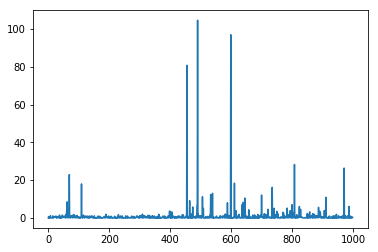

In [265]:
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [266]:
entropy(values)

tensor(6.94)

In [213]:
distance_from_uniform(values)

tensor(12.74)

In [177]:
#resnet33
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
finished creating histogram for the 0th perturbation
at batch no 0
finished creating histogram for the 1th perturbation
at batch no 0
finished creating histogram for the 2th perturbation
at batch no 0
finished creating histogram for the 3th perturbation
at batch no 0
finished creating histogram for the 4th perturbation
at batch no 0
finished creating histogram for the 5th perturbation
at batch no 0
finished creating histogram for the 6th perturbation
at batch no 0
finished creating histogram for the 7th perturbation
at batch no 0
finished creating histogram for the 8th perturbation
at batch no 0
finished creating histogram for the 9th perturbation
finished creating the prediction histogram


(645,
 [(904, 92.00),
  (646, 33.70),
  (611, 14.80),
  (750, 13.50),
  (506, 12.10),
  (971, 10.70),
  (741, 10.20),
  (808, 10.10),
  (916, 9.20),
  (721, 7.70),
  (824, 7.40),
  (769, 6.60),
  (489, 6.50),
  (580, 5.50),
  (703, 5.40),
  (893, 5.20),
  (692, 5.10),
  (582, 5.00),
  (496, 4.50),
  (905, 4.40),
  (411, 4.20),
  (806, 4.20),
  (922, 3.90),
  (84, 3.70),
  (752, 3.70),
  (565, 3.60),
  (754, 3.60),
  (963, 3.60),
  (621, 3.40),
  (55, 3.30),
  (911, 3.30),
  (982, 3.30),
  (549, 3.20),
  (94, 3.10),
  (709, 3.10),
  (879, 3.10),
  (151, 3.00),
  (128, 2.80),
  (273, 2.80),
  (562, 2.80),
  (850, 2.80),
  (890, 2.80),
  (230, 2.70),
  (987, 2.70),
  (313, 2.50),
  (454, 2.50),
  (474, 2.50),
  (134, 2.40),
  (417, 2.40),
  (533, 2.40),
  (46, 2.30),
  (595, 2.30),
  (641, 2.30),
  (645, 2.30),
  (854, 2.30),
  (864, 2.30),
  (310, 2.20),
  (472, 2.20),
  (783, 2.20),
  (826, 2.20),
  (284, 2.10),
  (292, 2.10),
  (539, 2.10),
  (616, 2.10),
  (633, 2.10),
  (805, 2.10),


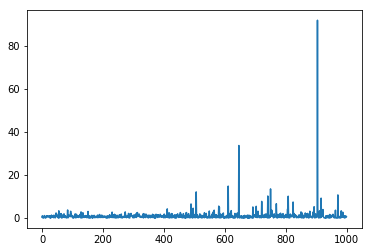

In [178]:
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [179]:
entropy(values)

tensor(8.62)

In [ ]:
def make_triplet_samples(z, margin, r2, r3):
  positive_sample = z + random_vector_volume(z.shape, 0, margin).cuda() 
  negative_sample = z + random_vector_volume(z.shape, r2, r3).cuda()
  return positive_sample, negative_sample

def random_vector_surface(shape, r = 1.):
  mat = torch.randn(size=shape).cuda()
  norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
  return (mat/norm) * r

def random_vector_volume(shape, inner_r, outer_r):
  fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
  fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
  fraction.unsqueeze_(-1)
  return random_vector_surface(shape, 1) * fraction

In [ ]:
from collections import Counter

def most_frequent(x):
  return Counter(x).most_common(1)[0]

def preds_around(center, radius, n_preds, model, dummy_img):
  z_s = random_vector_volume([n_preds, 10], radius, radius + 0.01) + center[None]
  noises = model.forward_z(z_s)
  perturbed_imgs = noises + dummy_img 
  return torch.argmax(arch(perturbed_imgs), 1)
  
def most_freq_pred_around(center, radius, n_preds, model, dummy_img):
  preds = preds_around(center, radius, n_preds, model, dummy_img)
  most_freq = most_frequent(preds.tolist())
  return (class_index_to_label(most_freq[0]), most_freq[1]/n_preds)

def investigate_neighborhood(z, step, model, dummy_img):
  with torch.no_grad():
    result = []
    for radius in np.arange(0.1, 6., step):
#       print("creating {} more preds".format(int(10 + 5 * (radius ** 2))))
      most_freq_pred = most_freq_pred_around(z, radius, int(10 + 5 * (radius ** 2)), model, dummy_img)
      result.append((radius, most_freq_pred))
    return result

In [ ]:
#experiment 1

z = torch.tensor([0.5] * 10).cuda()
# z = torch.empty(10).uniform_(-1, 1).cuda()
# z_s = z[None]

model = learn.model.eval()
x_img = normalize(learn.data.train_ds[50][0].data.cuda())
  
for i in range(6):
  z = torch.empty(10).uniform_(-1, 1).cuda()
  print("investigation for: ", z)
  for elem in investigate_neighborhood(z, 0.5, model, x_img):
    print(elem)
print("done")

In [ ]:
#experiment 1-1: modified investigate_z
z_investigate_path = '/root/Derakhshani/adversarial/textual_notes/investigate_z_{}.txt'.format(env.save_filename)
if Path(z_investigate_path).exists(): raise FileExistsError("file already exists")
file = open(str(z_investigate_path), 'w')
        
for i, (z, noise) in enumerate(zip(pruned_z_s, pruned_noises)):
  hist = compute_prediction_histogram(learn, noise)
  indexed_hist = [(i, val) for i, val in enumerate(hist)]
  sorted_hist = sorted(indexed_hist, key=lambda x: x[1], reverse=True)
  labeled_hist = [(class_index_to_label(i), count) for i, count in sorted_hist]
  print("result {}:".format(i))
  print(big_vector_to_str(z))
  print(labeled_hist[:6])
  print("\n\n")
  
  file.write("result {}:\n".format(i))
  file.write(big_vector_to_str(z) + "\n")
  file.write(str(labeled_hist[:6]))
  file.write("\n\n\n")
  file.flush()

In [ ]:
#experiment 2
import itertools
z_s = [torch.tensor(t).cuda() for t in itertools.product( *([[-0.33, 0.33]] * 10) )]
model = learn.model.eval()
noises = []
with torch.no_grad():
  for z in z_s:
    noises.append(model.forward_single_z(z))

In [ ]:
x_img = normalize(learn.data.train_ds[50][0].data.cuda())

preds = []
for noise in noises:
  perturbed_img = x_img + noise
  preds.append(torch.argmax(arch(perturbed_img[None]), 1)[0].item())

from collections import Counter
result = [(class_index_to_label(index), count) for index, count in Counter(preds).most_common(5)]
result

In [ ]:
#experiment 3
import itertools
dimension_values = [[-0.9, 0.9]] * z_dim
for i in range(z_dim):
  if i % 100 != 0:
    dimension_values[i] = [0.]
# dimension_values[0] = [0.]
# dimension_values[3] = [0.]
# dimension_values[6] = [0.]
# dimension_values[9] = [0.]
pruned_z_s = [torch.tensor(t).cuda() for t in itertools.product(*dimension_values)]
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
#experiment 3: for the targeted-attack case
pruned_z_s = []
for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
#experiment 3-1: noises for 
pruned_z_s = []
# for i in range(z_dim):
#   new_z = torch.empty(z_dim).uniform_(0,1).cuda().detach()
#   pruned_z_s.append(new_z)

for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda().detach()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
for noise in pruned_noises[0:200]:
  img = noise_to_image(noise)
  img.show()

In [ ]:
# spider web
z_values = [
  [ 0.33, -0.33,  0.33,  0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33],
  [-0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33],
  [-0.33,  0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33,  0.33,  0.33],
  [-0.33,  0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33],
  [ 0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33, -0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33, -0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()


In [ ]:
z_values = [
  # window screen
  [-0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()

In [ ]:
#vgg-16_12 most repeated labels:
l = [(611, 215.0),
  (474, 194.1),
  (398, 120.3),
  (721, 79.6),
  (741, 73.5),
  (510, 62.5)]

[(class_index_to_label(index), count) for index, count in l]

In [ ]:
# learn.recorder.plot_losses()
# learn.recorder.plot_lr()
# learn.recorder.plot_metrics()

In [ ]:
fooling_rates = []
model = learn.model.eval()
learn.metrics = [validation_single_perturbation]
for i in range(10):
  global_perturbations = model(torch.rand(1, 3, 224, 244).cuda())[0]
  nag_util.global_perturbations = global_perturbations
  fooling_rates.append(learn.validate()[1].cpu().item())
  print("%d : %f"%(i, fooling_rates[-1]))

mean = np.mean(fooling_rates)
stddev = np.std(fooling_rates)
print(mean, stddev); print(fooling_rates)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[200][0]
x = normalize(x_img.data.cuda())
z = torch.tensor([-0.33,  0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33], dtype=torch.float32).cuda()
# z = torch.empty(z_dim).uniform_(-1,1).cuda()
p = model.forward_single_z(z).detach()

p_x = x + p
# print("img range, noise range")
# print_range(x); print_range(p)
adv_label = class_index_to_label(arch(p_x[None]).argmax(1).item())
print_big_vector(arch(p_x[None])[0])
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0., 1.])
p_img = Image(p)
x_img.show()
p_img.show()
p_x_img.show()


# print_range(p)
# print_range(denormalize(x))
# print_range(p_x)

benign_label = class_index_to_label(arch(x[None]).argmax(1).item())

print_big_vector(arch(x[None])[0])
print(benign_label, adv_label)

In [ ]:
z1 = torch.tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p1 = model.forward_single_z(z1)

z2 = torch.tensor([1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p2 = model.forward_single_z(z2)

z3 = torch.tensor([1, 1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p3 = model.forward_single_z(z3)

l2_distance(p1, p3)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[4][0]
x = x_img.data[None].cuda()
p = model(x)[0].squeeze().detach() 
x = x.squeeze()
x = normalize(x)

p_x = x + p
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0.,1.])
p_img = Image(p)
# x_img.show()
p_img.show()
# p_x_img.show()

print_range(p)
print_range(x)
print_range(p_x)